In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from wpca import WPCA
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import re
import os
from datetime import date
import mygene         #for alternative method of changing ensembl names to gene symbols
mg = mygene.MyGeneInfo()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from porch import porch
from urllib.error import HTTPError, URLError
import time
import sys
from random import sample

/home/augjan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
def drop(df, col, key):
    '''
    Fuction to make it possible to drop rows of a dataframe (df) with a specific list as condition (key) in a specific column (col)
    '''
    m = [v == key for v in df[col]]
    df.loc[m, col] = float('NaN')
    df.dropna(inplace=True)
    return df

def TFs_targets(kbp, chip, MACS2, MAX): 
    '''
    Function for creating csv with all TFs and their target genes. For each TF, it identifies urls for target gene data, fetches the info and puts it into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set =  pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)-2):
                    col[i+1] = col[i+1].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1

    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

    return TF_gene_sets

def TFs_targets_strict_porch(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = str(TF_gene_set.loc[(TF_gene_set > 700).sum(axis=1)>0,:].reset_index()['Target_genes'].tolist()).replace("'","") #['Target_genes'] #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets = drop(TF_gene_sets, 'Genes', '[]')
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets

def Bigdict(kbp):
    '''
    Function for creating a dictionary of the data from ChIP-atlas so that gene sets can be created from
    different restrictions can be created without having to dowload the data each time.
    '''
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')
    
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    bigdict = {}
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                bigdict[chip.index[dex]] = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                bigdict[chip.index[dex]] = pd.DataFrame()
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    return bigdict
    
def TF_targets_dict(bigdict, MACS2, MAX, kbp):
    '''
    Function for creating gene sets with the data from Bigdict.
    '''
    TF_gene_list = []

    for TF in bigdict:
        TF_gene_set = bigdict[TF].copy()
        col = list(TF_gene_set.columns)
        for i in range(len(col)-2):
            col[i+1] = col[i+1].split('|',1)[1]
        TF_gene_set.columns = col
        TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col[1:-1]))
        for sample in TF_set.columns:
            TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
        TF_set['Max'] = TF_set.max(axis=1)
        genes = TF_set.loc[(TF_set > MACS2).sum(axis=1)>0,:].nlargest(n=MAX, columns='Max').index.tolist()
        TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs   
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=bigdict.keys()) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.index.name = 'Antigen'  
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes.astype(str) == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t')

def ID_to_symbol(datatsv): 
    '''
    Function for replacing the ensenbl gene IDs with gene symbols/names in dataframe with expression data
    '''
    dataset = pd.read_csv(datatsv, sep='\t') 
    symbols = pd.read_csv('../data/Gene_names.txt', index_col='Gene stable ID')
    symbols = symbols.drop_duplicates(keep=False)
    dataset = dataset.merge(symbols, left_on='Gene', right_on='Gene stable ID', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('Gene name', inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.index.rename('Symbol', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t')
    return dataset

def ID_to_symbolMG(datatsv):
    '''
    Alternative function for replacing the ensembl gene IDs with gene symbols/names in expression data, using MyGene package.
    '''
    dataset = pd.read_csv(datatsv, sep='\t')
    genes = dataset.loc[:,'Gene']
    genesyms = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', as_dataframe=True) #Look up gene symbols with mygene
    genesyms = genesyms.dropna(subset=['symbol'], how='any') #Drop genes where no gene symbol was identified
    genesyms = genesyms.loc[~genesyms.index.duplicated(keep=False)] #Drop genes for which multiple gene symbols were identified
    syms = genesyms.loc[:,'symbol']
    dataset = dataset.merge(syms, left_on='Gene', right_on='query', how = 'left')
    dataset.dropna(how='any', inplace=True)
    dataset.set_index('symbol', inplace=True)
    dataset.index.rename('Symbol',inplace=True)
    dataset.drop(columns='Gene', inplace=True)
    dataset.to_csv('../data/genes.raw.htseq2.symbolsMG.tsv', sep='\t')
    return dataset

def csv_fix(csv):
    '''
    Function that opens a csv file and removes quotes at the end and beginning of rows with quotes in them,
    and converst double quotes to single quotes.
    (The original chip_atlas_analysis_list.csv that was downloaded did not work,
    as it contained an extra '"' in the start and end of each row with '"' in it, and each '"' had an extra  '"')
    '''
    name, ext = os.path.splitext(csv)
    newfilename = '{name}_{add}{ext}'.format(name=name, add='CORRECTED', ext='.csv')
    with open(csv,'r+') as csv_file:
        for line in csv_file:
            # removing starting and ending quotes of a line
            pattern1 = re.compile(r'^"|"$',re.MULTILINE)
            line = re.sub(r'^"|"$',"",line)
            # substituting escaped quote with a single quote
            pattern2 = re.compile(r'""')
            line = re.sub(r'""','"',line)
            corrected_csv = open(newfilename,'a')
            corrected_csv.write(line)
            corrected_csv.close()
    csv_df = pd.read_csv(newfilename, quotechar = '"')
    return csv_df

def gene_sets(kbp, MACS2, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(MACS2)+'+MACS2_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets(kbp,chip,MACS2,MAX)
        
    return TF_gene_sets

    
def gene_sets_porch(kbp, MACS2):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_porch_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t', index_col='Antigen')
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_strict_porch(kbp, MACS2, chip)
        
    #Pick out gene sets with 500 or fewer genes
    TF_short_sets = TF_gene_sets.copy()
    for TF in TF_short_sets.index:
        if len(TF_short_sets.loc[TF,:][0]) > 500:
            TF_short_sets.drop([TF], inplace=True)
    return TF_gene_sets

def data_set():
    '''
    Fetch the longitudinal mRNA expression data and the sample specifications
    '''
    #Read in dataset with expression values and gene symbols. If not available, replace ensembl IDs and create the csv
    try:
        dataset = pd.read_csv('../data/genes.raw.htseq2.symbols.tsv', sep='\t', index_col='Symbol')
    except:
        ID_to_symbol('../data/genes.raw.htseq2.tsv')

    #Read in dataset with sample sepcifications
    dataset2 = pd.read_csv('../data/E-MTAB-2328.sdrf.tsv', sep='\t') #Read csv with specifications of assays
    return dataset, dataset2

def indexing(dataset, dataset2):
    '''
    Function that creates a dataframe with multi-colunindex of organ and developmental stage, index is genes
    '''
    #Exctract important characteristincs of samples from dataset2
    chars = pd.DataFrame()
    chars['assay'] = dataset2.loc[:,'Assay Name'].str.slice(stop=6)
    #chars['dev_stage'] = dataset2.loc[:,'Characteristics[developmental stage]']
    chars['organ'] = dataset2.loc[:,'Characteristics[organism part]']
    chars = chars.drop_duplicates()
    chars['dev_stage'] = [-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29,-5.5,-5.5,-2.5,-2.5,0.5,0.5,4,4,22,22,29,29]
    chars = chars.set_index('assay')

    #Insert the important characteristics into dataset with expression values as column index
    datasetT = dataset.T
    datasetT['dev_stage'] = datasetT.index.to_series().map(chars['dev_stage'])
    datasetT['organ'] = datasetT.index.to_series().map(chars['organ'])
    datasetT.set_index(['organ','dev_stage'], inplace=True)
    #expdata = datasetT.sort_index(level = 0).T
    expdata = datasetT.T
    return expdata

def weighted_pca(df, n_pc=1, standardize=True):
    '''
    Function for performing the PCA, using sklearn. 
    
    df - Dataframe with expression values
    '''
    x = df.values.T #Set x as transpose of only the numerical values of the dataframe
    if standardize:
#        x = x-x.mean()
#        x2 = x/x.std()
        standardizer = StandardScaler()
        x2 = standardizer.fit_transform(x) #Standardize the data (center to mean and scale to unit variance)
        
#        x2 = preprocessing.scale(x) #Standardize the data (center to mean and scale to unit variance)
    else:
        x2 = x
        
    x2 = np.nan_to_num(x2) #Change back NaN values to 0, so array is accepted by the PCA function
    
    weights = 0 + np.isfinite(x)
    kwds = {'weights': weights}
    display(weights.shape)
    n_pcs = min(df.shape[0],n_pc)
    #pca = PCA(n_components = n_pcs) #Set PCA parameters
    pca = WPCA(n_components = n_pcs).fit(x2,**kwds) #Fit data to model
    expl = pca.explained_variance_ratio_
    x3 = pca.transform(x2,**kwds) #Transform the data (apply dimensionality reduciton) and set x3 as principal components 
    out_df = pd.DataFrame(x3.T, index=list(range(1,n_pcs+1)), columns=df.columns).T #Create dataframe with vlues from the PCA and set columnindex as the PC number 

    cont = pd.DataFrame(index=df.index)
    for i in range(n_pcs):
        cont.loc[:,'PC{0} contribution'.format(i+1)] = pca.components_[i]**2
    cont.sort_values(by='PC1 contribution', ascending=False, inplace=True)
        
    while n_pcs < n_pc:
        expl = np.append(expl,float('NaN'))
        n_pcs += 1
        out_df.loc[:,str(n_pcs)] = float('NaN')

    return out_df, expl, cont

def run_weighted_pca(expdata, TF_gene_sets, Other_results, n_pc=1):
    '''
    Function that uses weighted_pca on supplied dataframe
    '''
    PCA_per_TF = {}
    Contributions = {}
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)] = pd.DataFrame(index=expdata.columns)
    for TF in TF_gene_sets.index: 
        genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
        genesIndex.set_index('Genes', inplace=True)  
        genes = genesIndex.index.intersection(expdata.index)
        if len(genes)>2:
            TFdata = expdata.loc[genes,:]
            [res, expl, cont] = weighted_pca(TFdata, n_pc)
            Contributions[TF] = cont
            for i in range(n_pc):
                PCA_per_TF['PC{0}'.format(i+1)][TF] = res.iloc[:,i]
                PCA_per_TF[TF] = res.iloc[:,0]
                Other_results.loc[TF,'Gene count'] = len(genes)
                Other_results.loc[TF,'Variance explained PC'+str(i+1)] = expl[i]
        else:
            print(TF+' has less than 3 genes associated with it and is therefore disregarded.')
            Other_results.drop(TF)
    for i in range (n_pc):
        PCA_per_TF['PC{0}'.format(i+1)].sort_index(inplace=True)
    return PCA_per_TF, Other_results, Contributions

def ANOVA(PCA_per_TF, Other_results):
    '''
    Perform two-way ANOVA with statsmodels anova_lm for each TF separately and return a dataframe with p-values
    '''
    for TF in Other_results.index:
        test_data = pd.DataFrame(PCA_per_TF.loc[:,TF])
        test_data = test_data.reset_index()
        test_data.columns = ["organ", "dev_stage", "TF_expr"]
        TF_lm = ols('TF_expr ~ C(organ)+C(dev_stage)+C(organ):C(dev_stage)', data=test_data).fit()
        table = sm.stats.anova_lm(TF_lm, typ=2)
        Other_results.loc[TF,'C(organ)'] = table.iloc[0,3]
        Other_results.loc[TF,'C(dev_stage)'] = table.iloc[1,3]
        Other_results.loc[TF,'C(organ):C(dev_stage)'] = table.iloc[2,3]
    return Other_results

def ANOVAone(PCA_per_TF, Other_results):
    '''
    Perform one-way ANOVA with statsmodels anova_lm for each TF separately and return a dataframe with p-values
    '''
    for TF in Other_results.index:
        test_data = pd.DataFrame(PCA_per_TF.loc[:,TF])
        test_data = test_data.reset_index()
        test_data.columns = ["dev_stage", "TF_expr"]
        TF_lm = ols('TF_expr ~ C(dev_stage)', data=test_data).fit()
        table = sm.stats.anova_lm(TF_lm, typ=2)
        Other_results.loc[TF,'C(dev_stage)'] = table.iloc[0,3]
    return Other_results

def save_exp(data, filename):
    '''
    Save data from performed experiments as tsv file in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    data.to_csv('../exp/'+str(date.today())+'/'+filename+'.tsv', sep='\t')
        
def save_fig(figure, A, B):
    '''
    Save a figure as a png in a date-specific subfolder of exp
    '''
    if os.path.isdir('../exp/'+str(date.today())) == False:
        os.mkdir('../exp/'+str(date.today()))
    figure.savefig('../exp/'+str(date.today())+'/'+A+'_'+B+'_plot.png', bbox_inches="tight")

def disthist(Other_results):
    '''
    Plot histogram for p-value distribution inlcluding all three tested groups
    '''
    bins = np.linspace(0,1, 51)
    plt.figure(figsize=(16,8))
    for variable in [var for var in Other_results.columns if 'C(' in var]:
        plt.hist(Other_results.loc[:,variable], bins, alpha=0.5, label=variable)
    plt.legend(loc='upper right')
    plt.xlabel('p-value')
    plt.ylabel('Number of TFs')
    plt.title('p-value histogram')
    save_fig(plt,'p-value','histogram')
    plt.show()
    
def lowp(Other_results):    
    '''
    Make and show dataframes with TFs with a p-value below Bonferroni corrected 0.05 for each of the groups tested
    '''
    for var in [var for var in Other_results.columns if 'C(' in var]:
        low_p_vals = Other_results.loc[Other_results[var]<(0.05/len(Other_results))]
        low_p_vals.sort_values(by=var, inplace=True)
    return low_p_vals

def activityplot(TF_list, PCA_results, logdata, organ='', hue=None, style=None):
    '''
    Function for plotting TF principal component and gene expression over time
    '''
    PCA_results = -PCA_results
    for TF in TF_list.index:
        fig, axes = plt.subplots(1,2, figsize=(32,16)) #, gridspec_kw={'height_ratios': [1,x]})
        #Plot the combined PC expression for TFs in list
        PC_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=PCA_results.reset_index(), ax=axes[0])        
        axes[0].set_xlabel('Developmental stage (days)')
        axes[0].set_ylabel('Log2 expression')
        axes[0].set_title(TF+' PC expression'+organ)
        #Plot the gene expression for the TFs in list
        Gene_plot = sns.lineplot(x='dev_stage', y=TF, hue=hue, style=style, data=logdata.T.sort_index().reset_index(), ax=axes[1])
        axes[1].set_xlabel('Developmental stage (days)')
        axes[1].set_ylabel('Log2 expression')
        axes[1].set_title(TF+' gene expression'+organ)
        save_fig(plt,TF,organ)
    plt.show()
    
def TF_selection(logdata, TF_gene_sets, which=''):
    '''
    Function for selecting TFs with high and varying gene expression for the first test of the method
    '''
    genes = TF_gene_sets.index.intersection(logdata.index)
    if which == 'Random':
        genes = sample(list(genes),10)
    elif which == 'Top':
        logdata = logdata.loc[genes,:]
        mean = logdata.mean().mean()
        for gene in logdata.index:
            if logdata.loc[gene,:].mean()<mean:
                logdata.drop(gene, inplace=True)
            else:
                logdata.loc[gene,'Variance'] = np.var(logdata.loc[gene,:])
        logdata.sort_values(by='Variance', inplace=True)
        genes = logdata.nlargest(n=10, columns='Variance').index.tolist()
    return genes    
    
def main (kbp, MACS2, genelim, organ=None):
    '''
    Main function for running the primary experiment
    '''
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    TF_gene_sets = gene_sets(kbp, MACS2)
    for TF in TF_gene_sets.index:
        if len(TF_gene_sets.loc[TF,:][0])>genelim or len(TF_gene_sets.loc[TF,:][0])<2:
            TF_gene_sets.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    expdata = expdata + 1
    logdata = np.log2(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    #Prepare a dataframe to store all results that are not the PCA values for each sampling point
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    #Run PCA on the prepared dataframe, giving the PC values for each TF and how much of the data the the first PC explains
    [PCA_results, Other_results] = run_weighted_pca(logdata, TF_gene_sets, Other_results)
    #Perform ANOVA
    if organ == None:
        Other_results = ANOVA(PCA_results, Other_results)
    else:
        Other_results = ANOVAone(PCA_results, Other_results)
    #Plot the p-value distribution for differences between organs, developmental stages, and the combination of the two variables
    disthist(Other_results)
    #Pick out low p-values, based on Bonferroni multiple hypothesis corrected significance threshold of 0.05 
    low_p_vals = lowp(Other_results)
    #Plot the expression over time for TFs with low p-value, both their principal component and own gene expression data
    if organ == None:
        activityplot(low_p_vals, PCA_results, logdata)
    else:
        activityplotsep(low_p_vals, PCA_results, logdata, organ)
    #Save the acquired results as tsv files
    save_exp(PCA_results, 'PCA_results')
    save_exp(Other_results, 'Other_results')
    return PCA_results, Other_results

def main2(kbp, MACS2, MAX, n_pc=1, PC=1, organ=None, which=''):
    '''
    Main function for running the new primary experiment
    '''
    TF_gene_sets = gene_sets(kbp,MACS2,MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization
#    expdata = expdata.iloc[:,:]  #Seems unnecessary, what is the point?
    print('Here we go...')
    lim = expdata.shape[1]*0.25
    for gene in expdata.index: #Remove genes for which >25% of samples had no expression
        if expdata.loc[gene,:].tolist().count(0) > lim:
            expdata.drop(gene, inplace=True)
    print('Done')
    print(expdata.shape)
    
    expdata = expdata + 1 #Prepare 0-values for log transformation
    logdata = np.log2(expdata)

    logdata = component_removal(logdata, 1)    
    
    if organ != None:
        logdata = logdata.loc[:,organ]    
    
    logdata.replace(0,float('NaN'), inplace=True)

    TFs = TF_selection(logdata,TF_gene_sets, which=which)

    Other_results = pd.DataFrame(index=TF_gene_sets.loc[TFs,:].index)
    [PCA_results, Other_results, Contributions] = run_weighted_pca(logdata,TF_gene_sets.loc[TFs,:],Other_results, n_pc)
    
    #genelist = ['Txndc11','Ireb2','Cacybp']
    if organ == None:
    #    for gene in genelist:
    #        sns.lineplot(x='dev_stage', y=gene,hue='organ', data=logdata.T.sort_index().reset_index())
    #        plt.show()
        
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,hue='organ',style='organ')
    else:
    #    for gene in genelist:
    #        sns.lineplot(x='dev_stage', y=gene, data=logdata.T.sort_index().reset_index())
    #        plt.show()
        
        activityplot(Other_results,PCA_results['PC{0}'.format(PC)],logdata,organ=' '+organ)
    for a in Contributions:
        print('Gene contributions for TF {0}:'.format(a))
        display(Contributions[a])
        print('Variance explained by PC{1} for TF {0}: '.format(a,PC))
        display(Other_results.loc[a,'Variance explained PC{0}'.format(PC)])
    return PCA_results, Other_results, Contributions

In [16]:
def testall(n_pc=1, PC=1, organ=None):
    '''
    Function for performing PCA on the full gene set and plot the results
    '''
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization

    print('Here we go...')
    lim = expdata.shape[1]*0.25
    for gene in expdata.index: #Remove genes for which >25% of samples had no expression
        if expdata.loc[gene,:].tolist().count(0) > lim:
            expdata.drop(gene, inplace=True)
    print('Done')
    TF_gene_set = pd.DataFrame(data={'Antigen':['All'], 'Genes':[expdata.index.values]})
    TF_gene_set.set_index('Antigen',inplace=True)
    
    expdata = expdata + 1
    logdata = np.log2(expdata)
    
    if organ != None:
        logdata = logdata.loc[:,organ]
    
    display(TF_gene_set)
    Other_results = pd.DataFrame(index=['All'])
    [PCA_results, Other_results, Contributions] = run_weighted_pca(logdata,TF_gene_set,Other_results, n_pc)
    if organ == None:
        sns.lineplot(x='dev_stage', y='All', hue='organ', style='organ', data=PCA_results['PC{0}'.format(PC)].reset_index())        
    else:
        sns.lineplot(x='dev_stage', y='All', data=PCA_results['PC{0}'.format(PC)].reset_index())        
    return PCA_results, Other_results, Contributions

In [17]:
def component_removal(data, n_comp):
    mean = data.mean(axis=1)
    data.sub(mean, axis=0)
    
    dataT = data.T.values
    
    weights = 0 + np.isfinite(dataT)
    kwds = {'weights': weights}
    
    pca = WPCA(n_components = 30).fit(dataT,**kwds) #Fit data to model

    reconstruction = np.dot(pca.transform(dataT)[:,n_comp:], pca.components_[n_comp:,:])
    reconst_df = pd.DataFrame(data=reconstruction.T, columns=data.columns, index=data.index)
    reconst_df.add(mean,axis=0)
    
    return reconst_df

In [7]:
def reconstruct(organ=None):
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization

    print('Here we go...')
    lim = expdata.shape[1]*0.25
    for gene in expdata.index: #Remove genes for which >25% of samples had no expression
        if expdata.loc[gene,:].tolist().count(0) > lim:
            expdata.drop(gene, inplace=True)
    print('Done')
    TF_gene_set = pd.DataFrame(data={'Antigen':['All'], 'Genes':[expdata.index.values]})
    TF_gene_set.set_index('Antigen',inplace=True)
    
    expdata += 1
    logdata = np.log2(expdata)

#    standardizer = StandardScaler()
#    data = standardizer.fit_transform(logdata.values.T)

    mean = logdata.mean(axis=1)
    logdata.sub(mean, axis=0)  
    
    if organ != None:
        logdata = logdata.loc[:,organ]
    
    data = logdata.T.values
    
    TF_gene_set = pd.DataFrame(data={'Antigen':['All'], 'Genes':[expdata.index.values]})
    TF_gene_set.set_index('Antigen',inplace=True)
    
    weights = 0 + np.isfinite(data)
    kwds = {'weights': weights}
    n_pcs = 30
    
    pca = WPCA(n_components = n_pcs).fit(data,**kwds) #Fit data to model

    reconstruction = np.dot(pca.transform(data)[:,2:], pca.components_[2:,:])
    reconst_df = pd.DataFrame(data=reconstruction.T, columns=logdata.columns, index=logdata.index)
    reconst_df.add(mean,axis=0)
    #components = pca.transform(data)
    #reduced = pca.inverse_transform(components[:,2:])
    return reconst_df

In [9]:
def desc():
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    expdata.describe().T.to_csv('../data/data_char.tsv', sep='\t')
    
    
    expdata = expdata + 1
    logdata = np.log2(expdata)
    logdata.describe().T.to_csv('../data/logdata_char.tsv', sep='\t')

    normal = preprocessing.scale(logdata.values.T)
    normaldf = pd.DataFrame(data=normal.T, columns=logdata.columns, index=logdata.index)
    normaldf.describe().T.to_csv('../data/normdata_char.tsv', sep='\t')
    
    return expdata.describe().T, logdata.describe().T, normaldf.describe().T

In [11]:
#Prepare data and perform SVD to test sample behaviour
[dataset, dataset2] = data_set()
expdata = indexing(dataset,dataset2)
expdata = expdata/(expdata.sum()/10**6) #Reads/transcripts per million normalization

print('Here we go...')
lim = expdata.shape[1]*0.25
for gene in expdata.index: #Remove genes for which >25% of samples had no expression
    if expdata.loc[gene,:].tolist().count(0) > lim:
        expdata.drop(gene, inplace=True)
print('Done')

expdata = expdata + 1
logdata = np.log2(expdata)

standardizer = StandardScaler()
data = standardizer.fit_transform(logdata.values.T)

u, s, vh = np.linalg.svd(data.T)
#uu, ss, vvh = np.linalg.svd(expdata-1)

Here we go...
Done


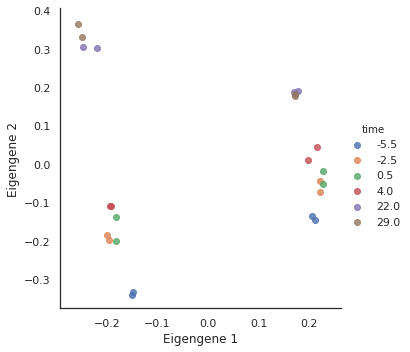

In [80]:
#Plot sample behaviour
sep = 'time'
df = pd.DataFrame(vh[0:2,:].T, columns=['Eigengene 1','Eigengene 2'])
df.loc[:,'organ'] = logdata.columns.get_level_values(0)
df.loc[:,'time'] = logdata.columns.get_level_values(1)
sns.set_style('white')
plot = sns.lmplot(x='Eigengene 1', y='Eigengene 2', data=df, hue=sep, fit_reg=False)

plt.show()
save_fig(plot,'SampleBehaviour',sep)

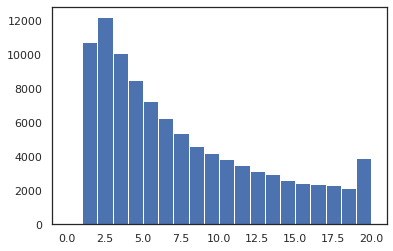

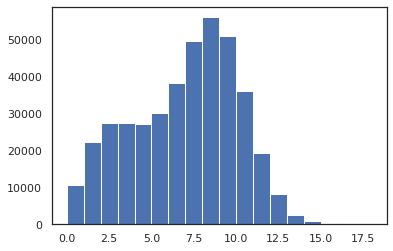

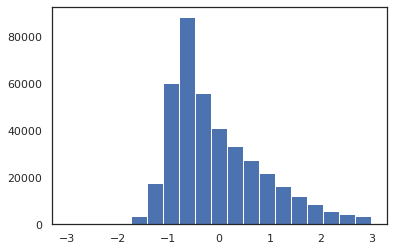

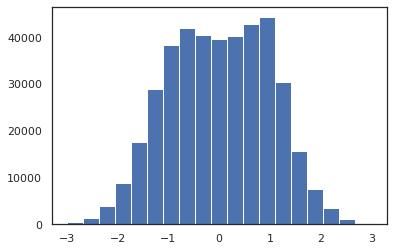

In [109]:
#Plot data distribution
[dataset, dataset2] = data_set()
expdata = indexing(dataset,dataset2)
print('Here we go...')
lim = expdata.shape[1]*0.25
for gene in expdata.index: #Remove genes for which >25% of samples had no expression
    if expdata.loc[gene,:].tolist().count(0) > lim:
        expdata.drop(gene, inplace=True)
print('Done')

expdata = expdata + 1
logdata = np.log2(expdata)

bins1 = np.linspace(0,20,21)
plt.hist(np.concatenate(expdata.loc[:,:].values), bins1)
plt.show()
bins2 = np.linspace(0,18,19)
plt.hist(np.concatenate(logdata.loc[:,:].values), bins2)
plt.show()

zdata1 = pd.DataFrame(data = stats.zscore((expdata-1).values,axis=1), columns=logdata.columns, index=logdata.index)
bins3 = np.linspace(-3,3,20)
plt.hist(np.concatenate(zdata1.loc[:,:].values), bins3)
plt.show()

zdata2 = pd.DataFrame(data = stats.zscore(logdata.values,axis=1), columns=logdata.columns, index=logdata.index)
bins4 = np.linspace(-3,3,20)
plt.hist(np.concatenate(zdata2.loc[:,:].values), bins4)
plt.show()

Here we go...
Done


Genes
Antigen                                                   
All      [Gnai3, Cdc45, H19, Scml2, Apoh, Narf, Cav2, K...

(12, 16984)

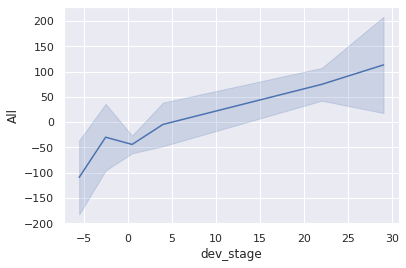

In [17]:
[A,B,C] = testall(n_pc=20, PC=1)

Here we go...
Done
(16984, 24)


(12, 95)

(12, 24)

(12, 70)

(12, 81)

(12, 71)

(12, 92)

(12, 14)

(12, 81)

(12, 80)

(12, 5)

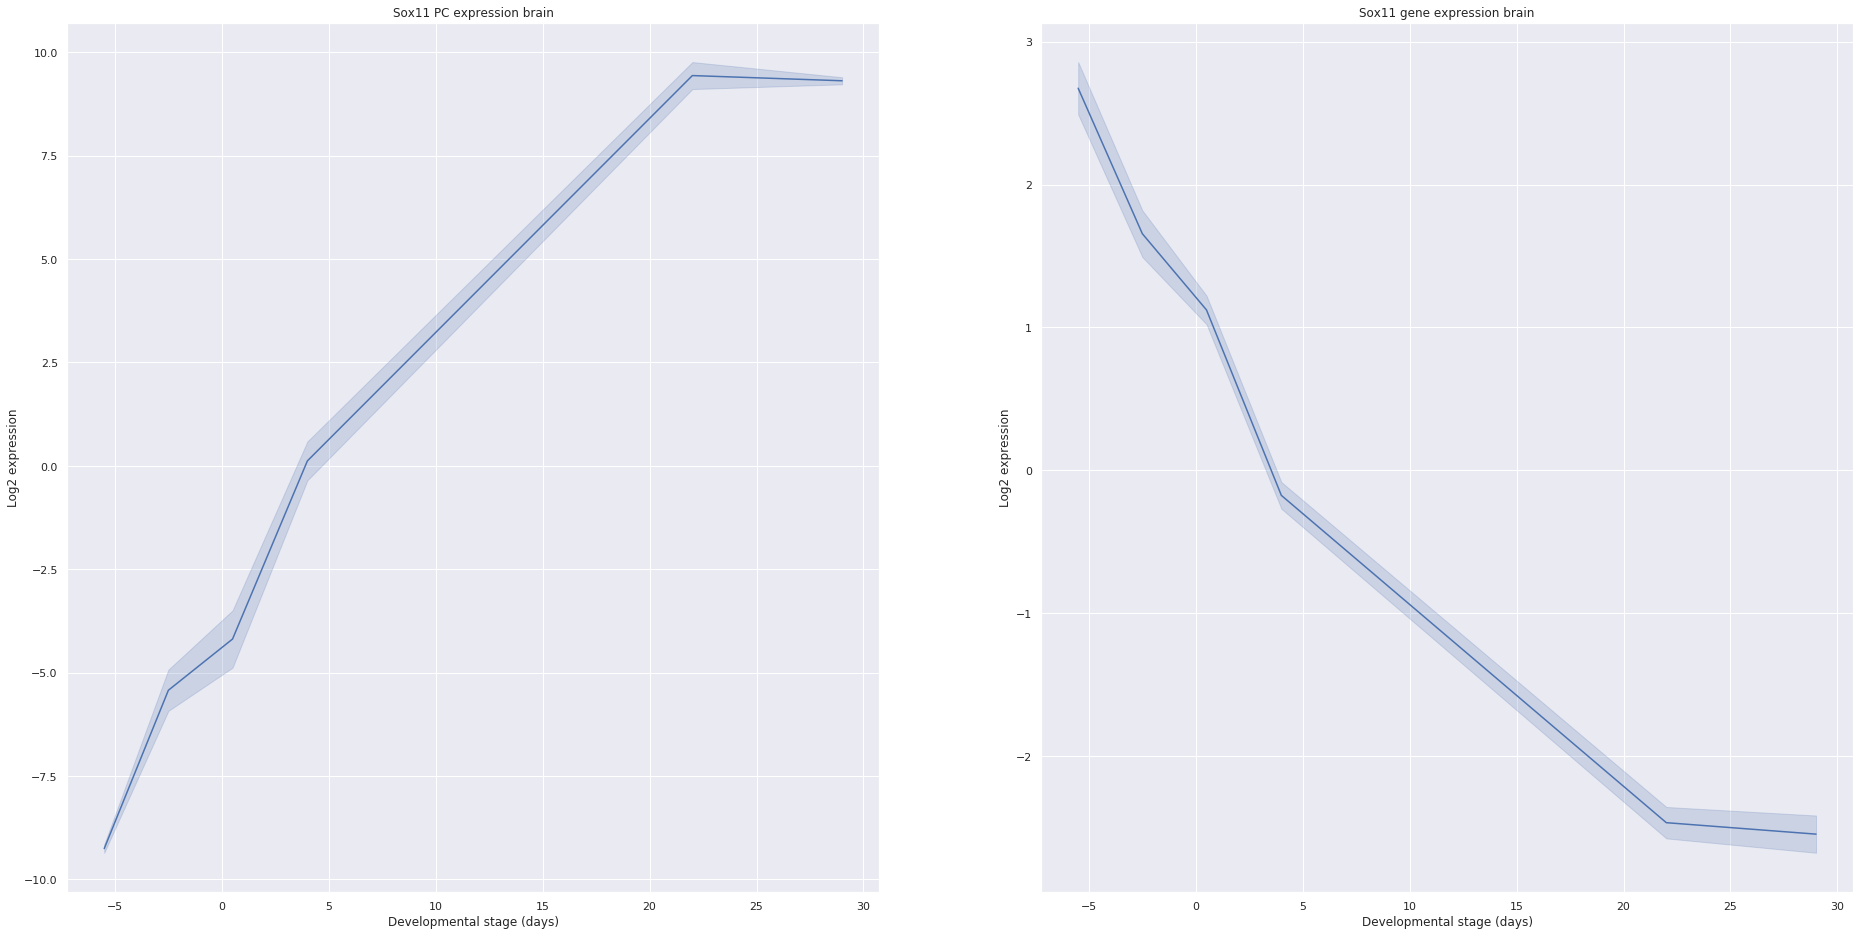

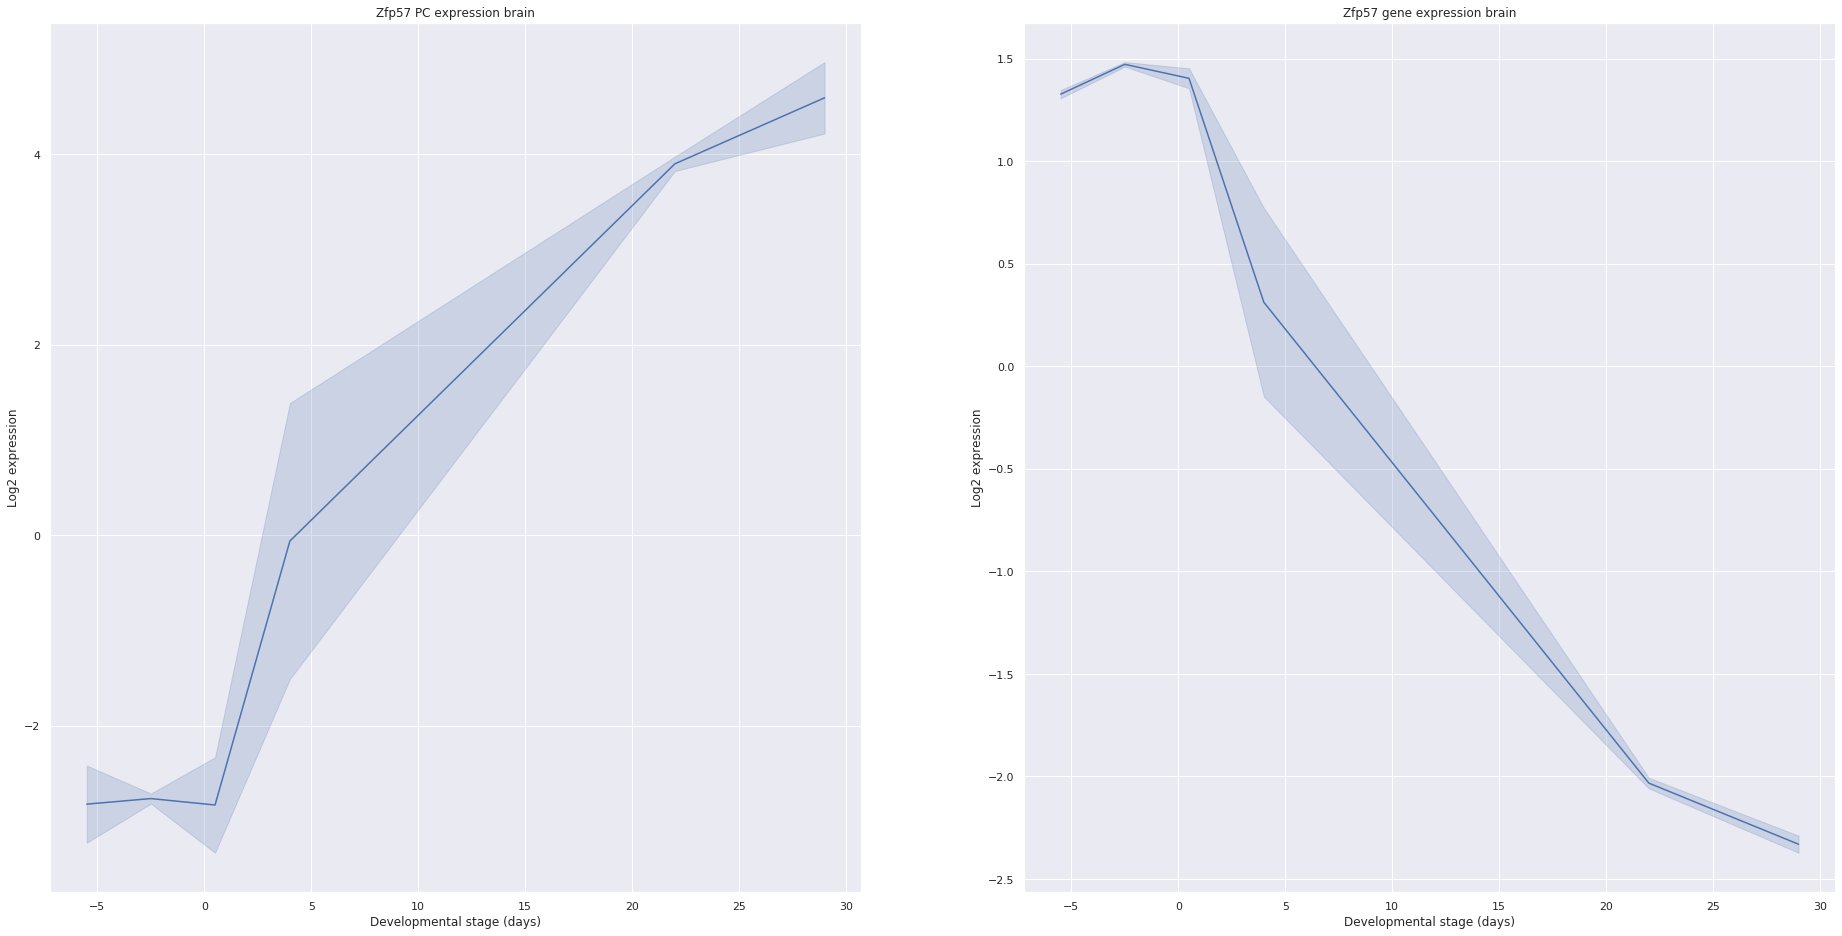

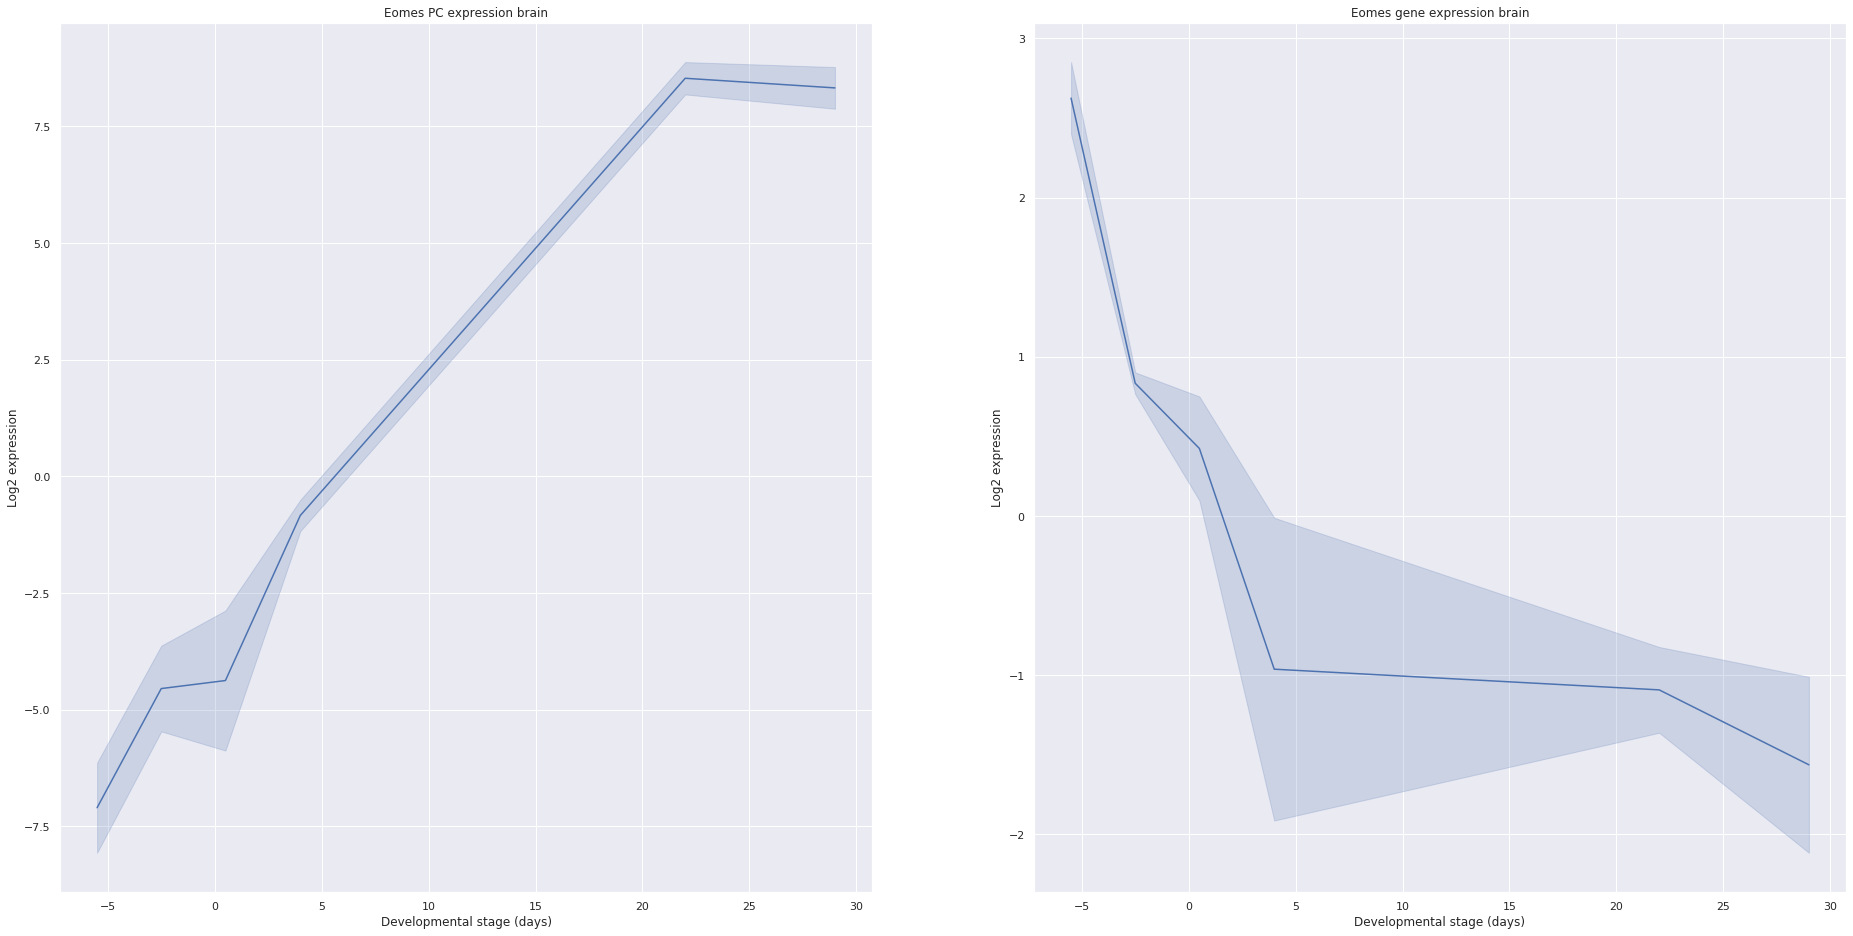

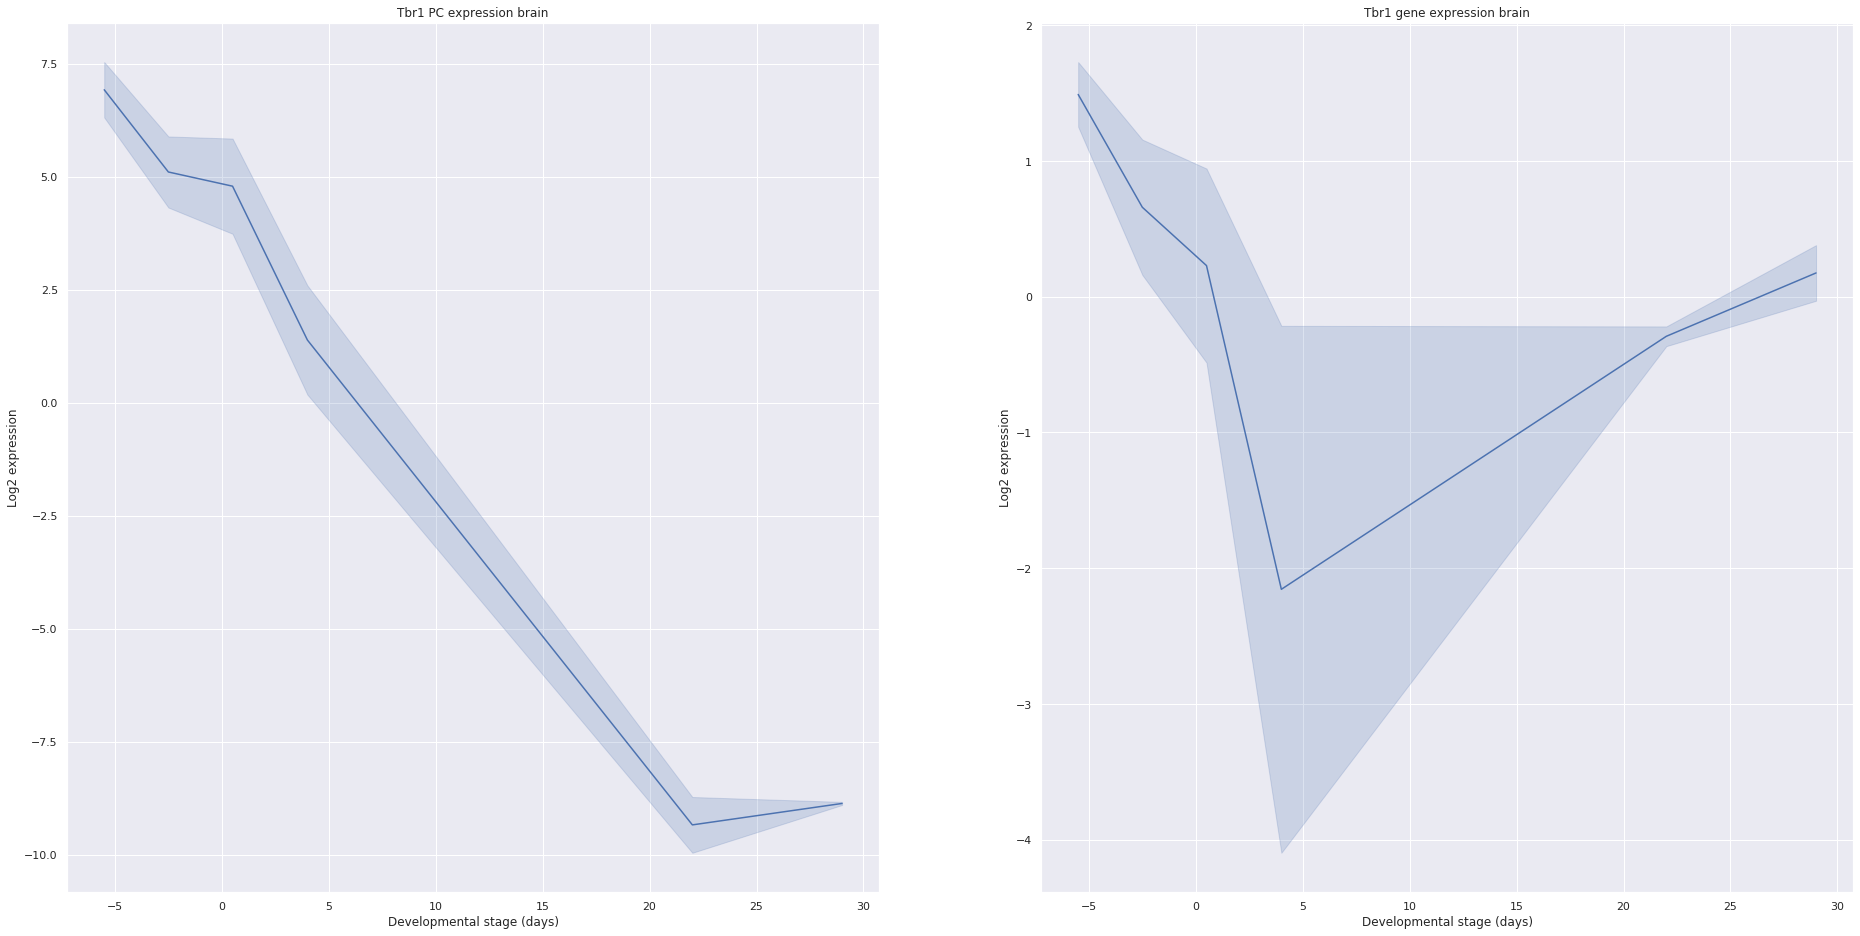

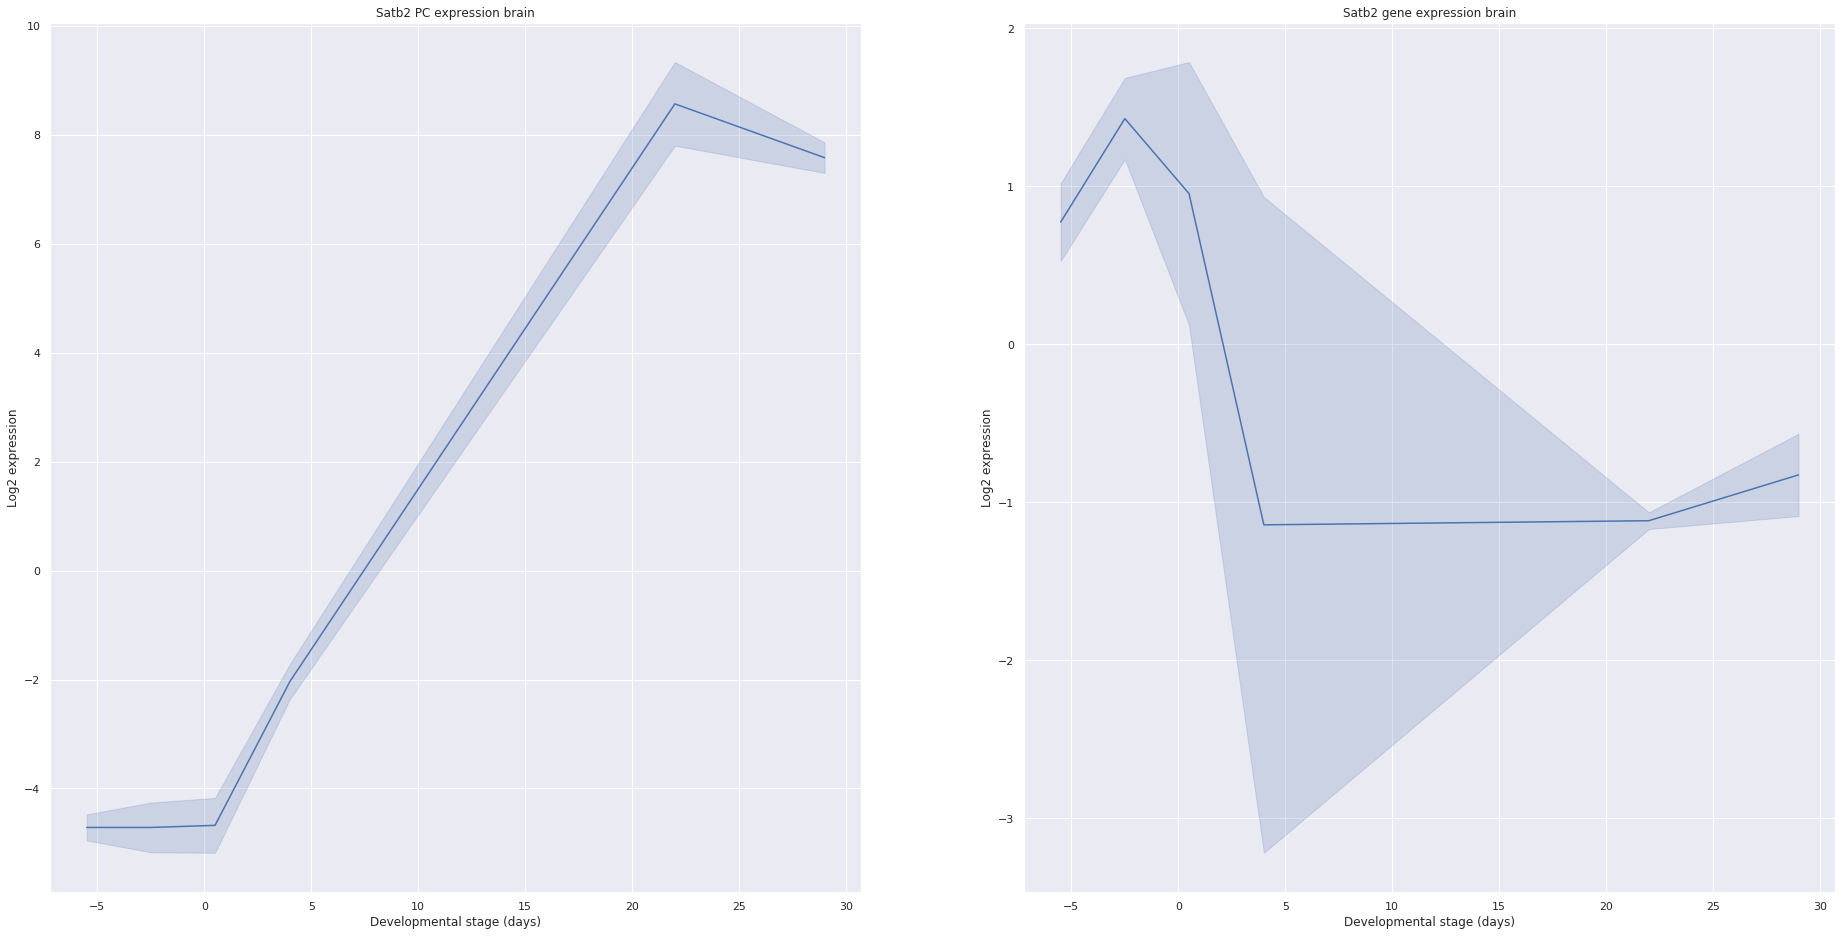

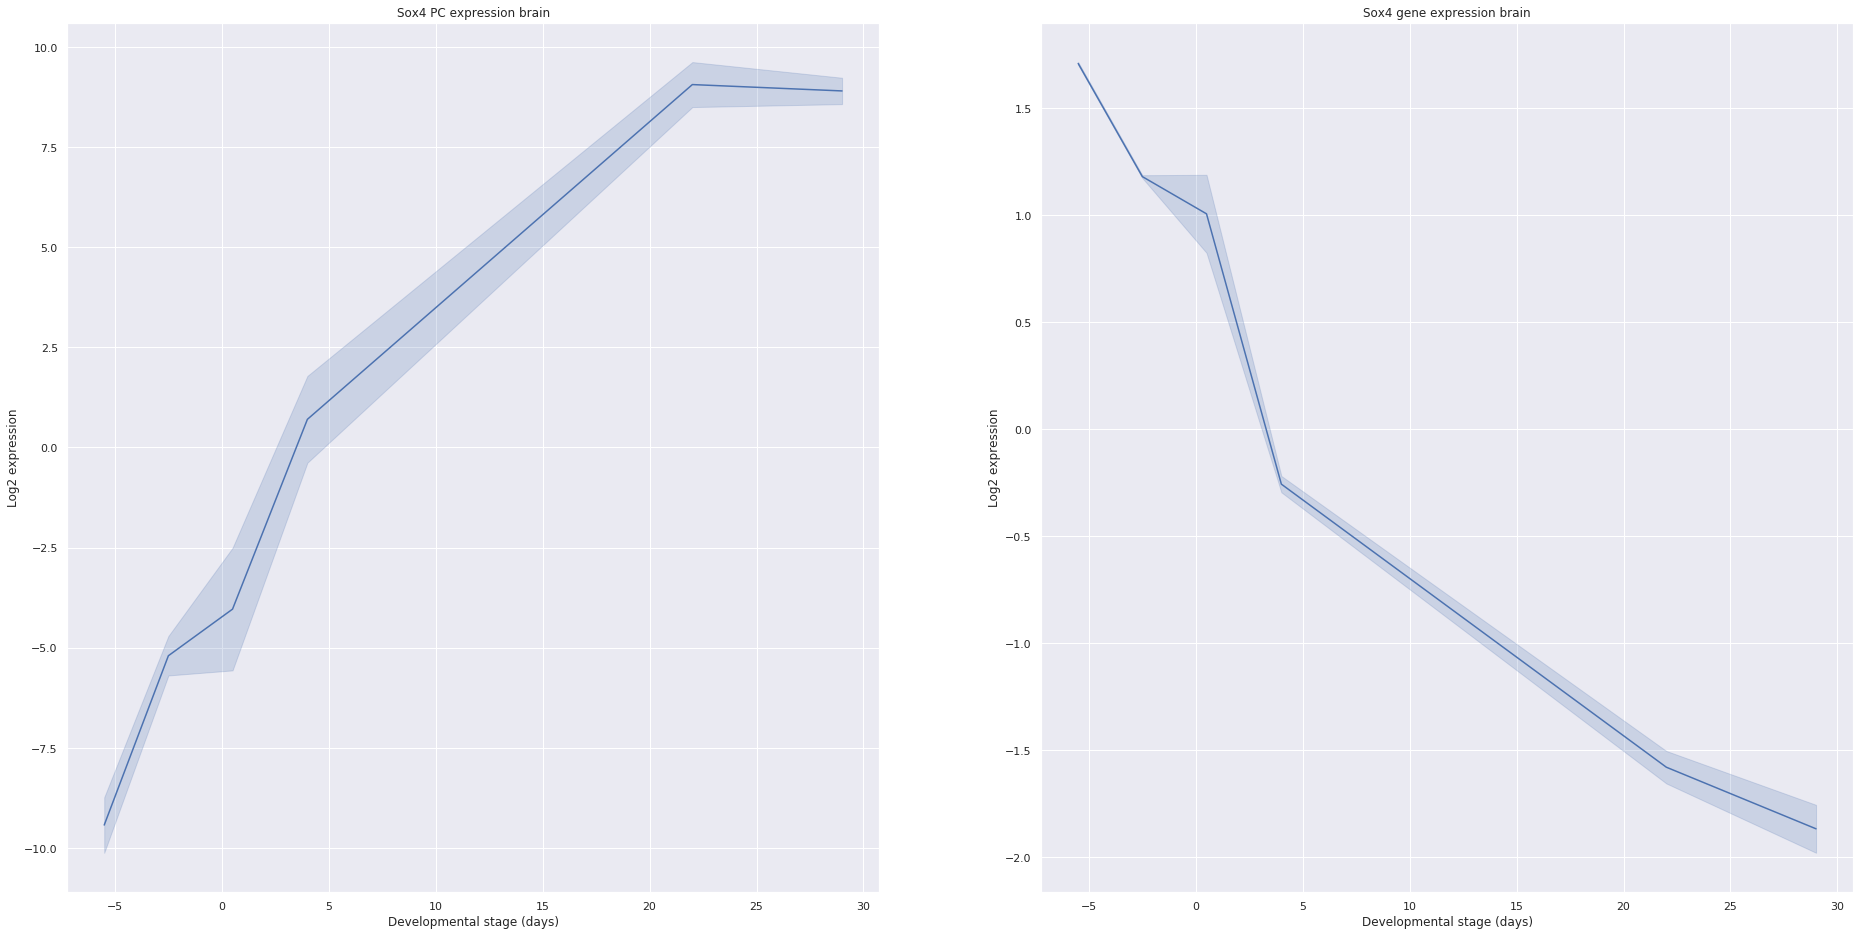

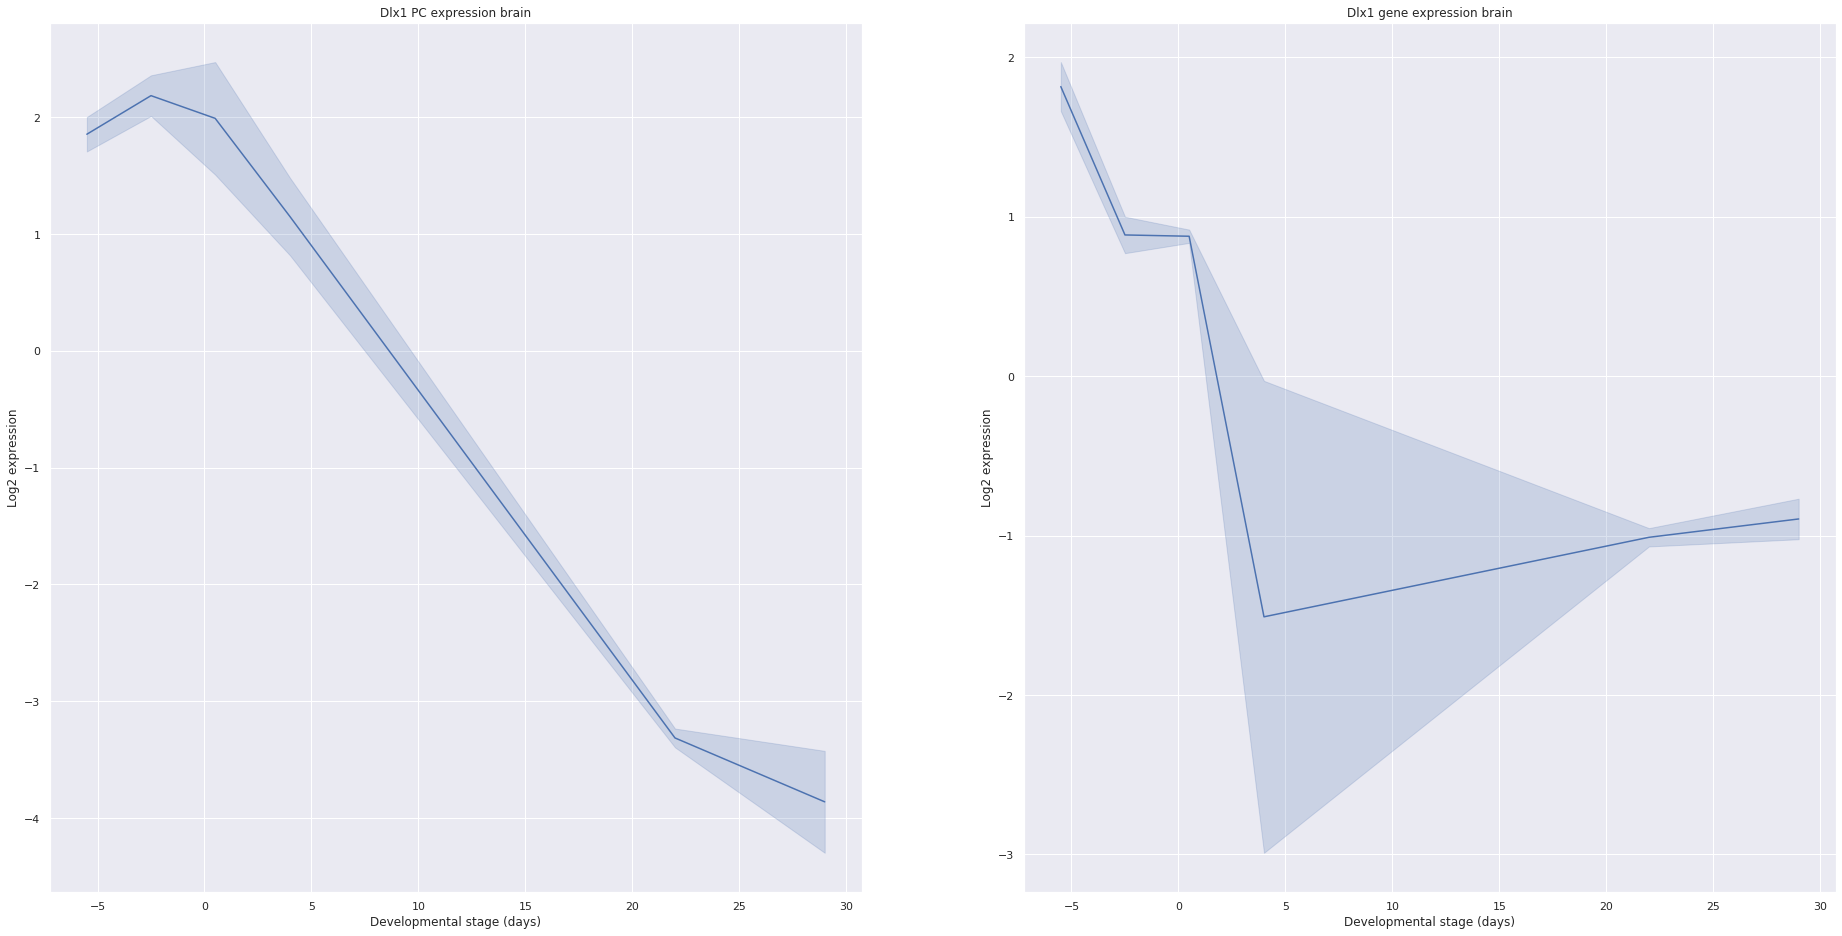

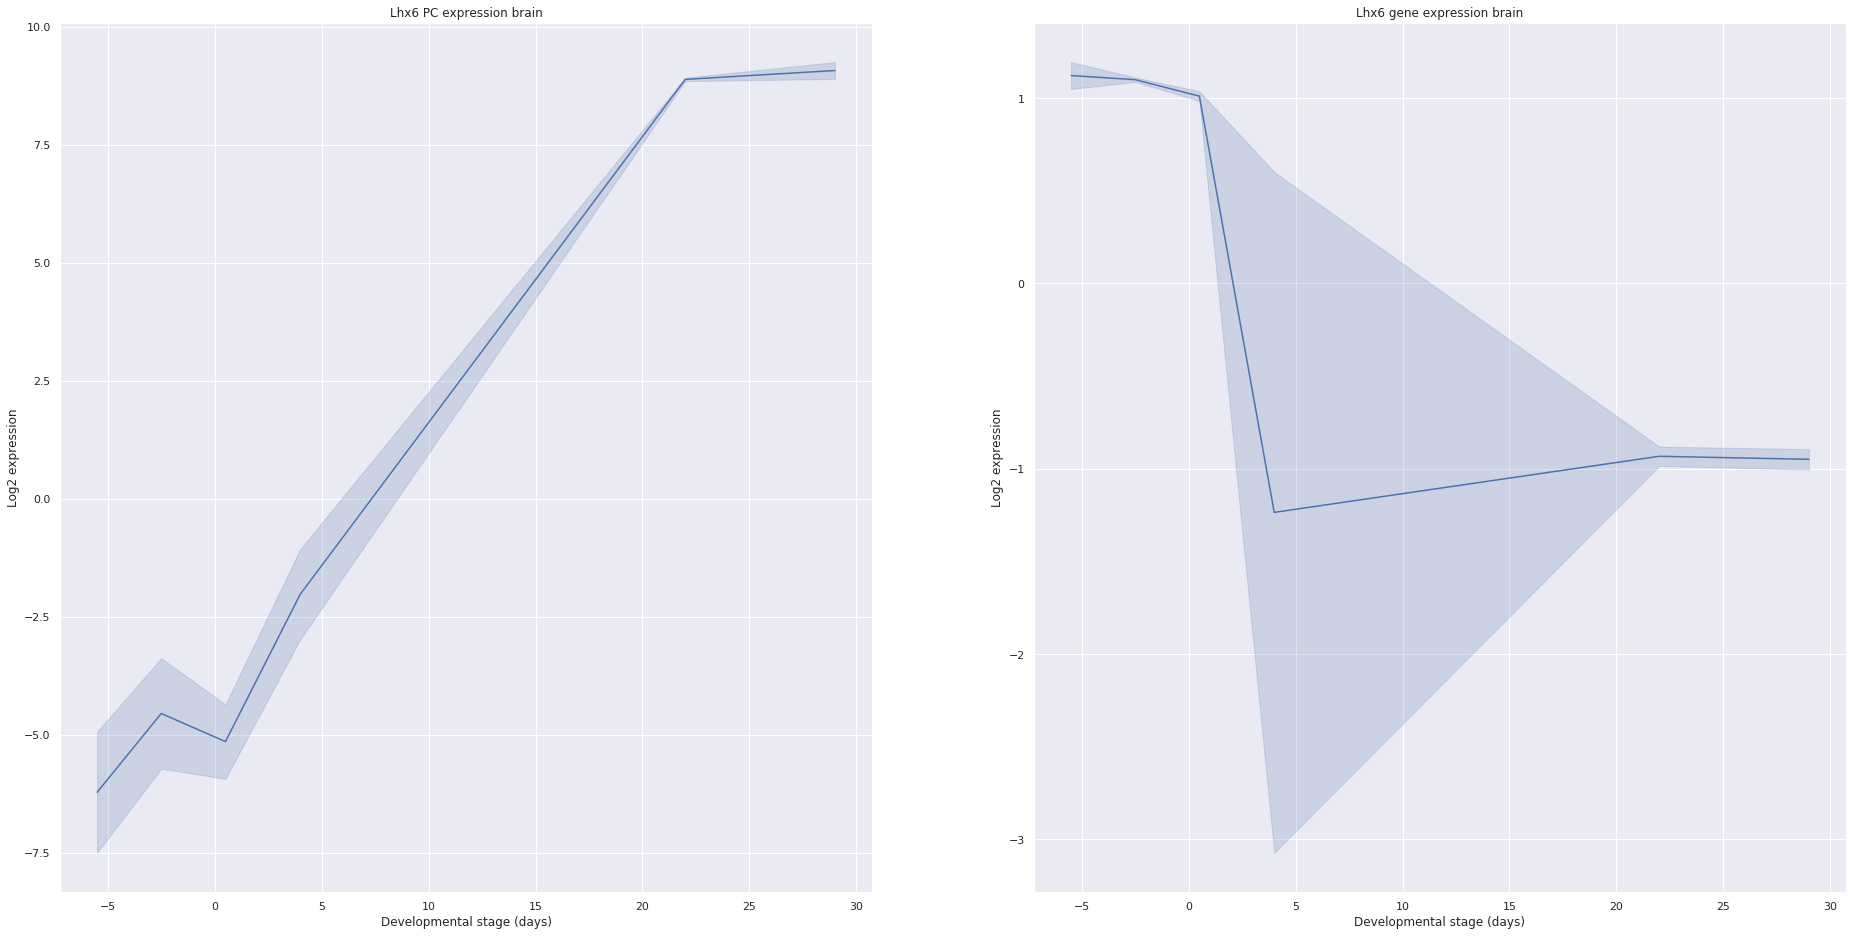

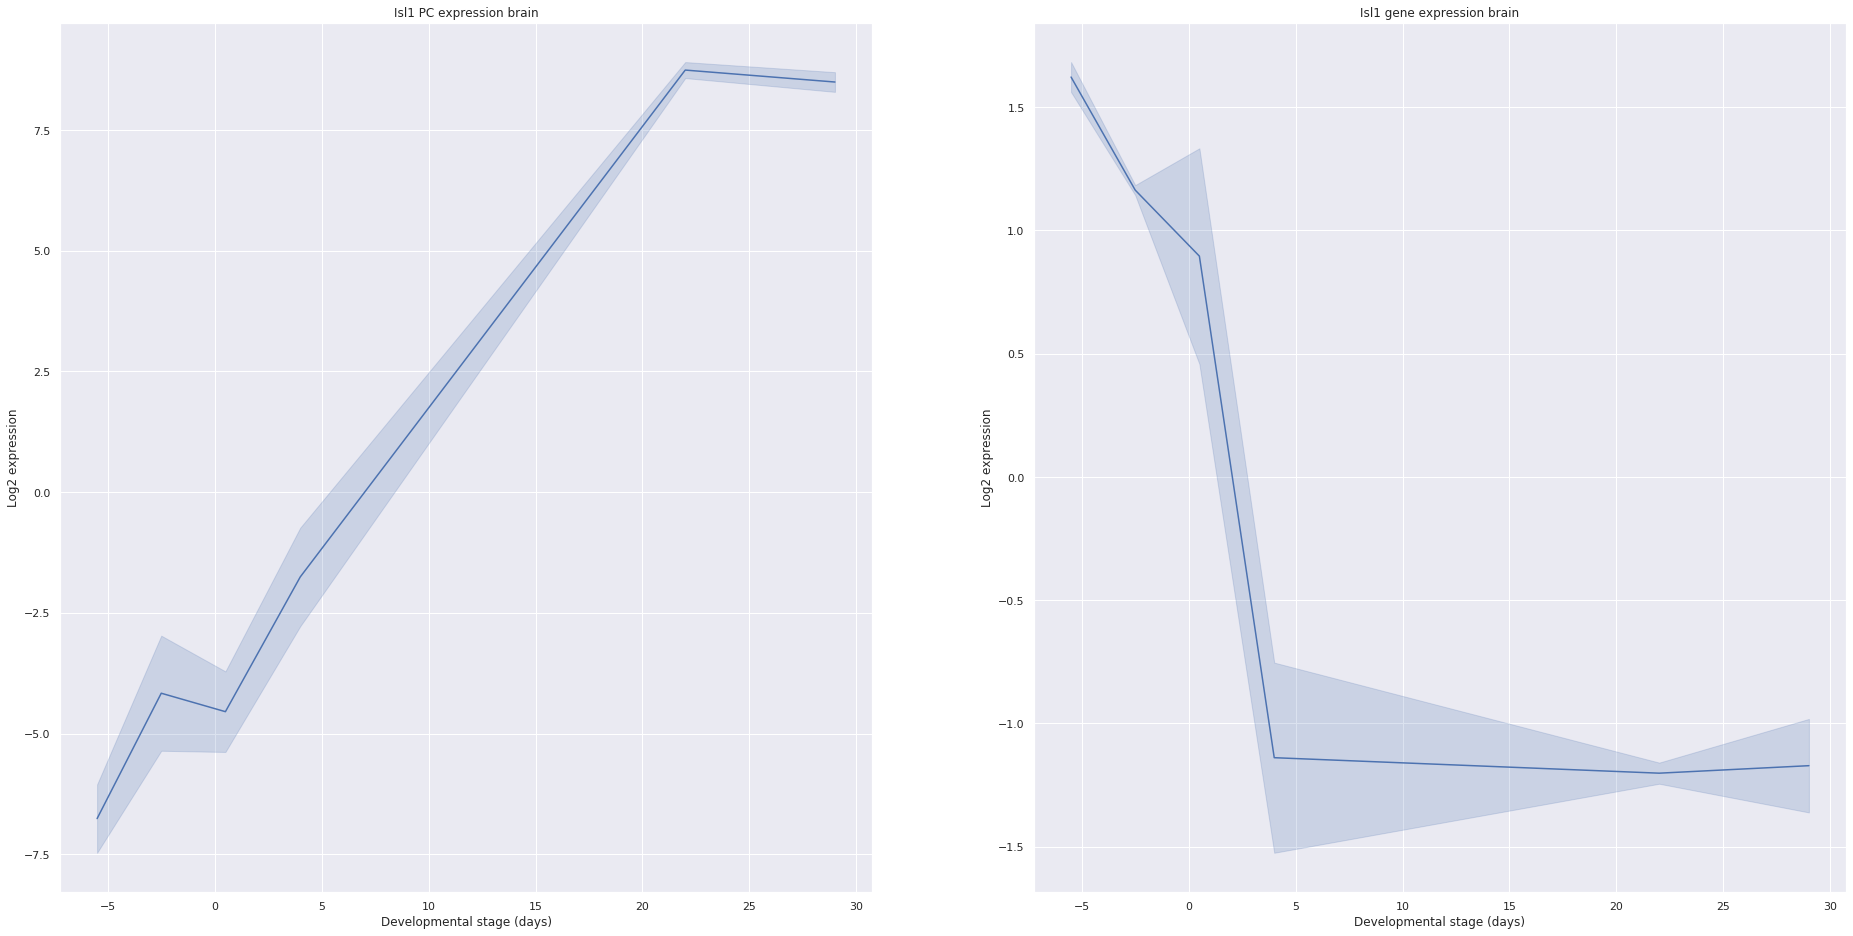

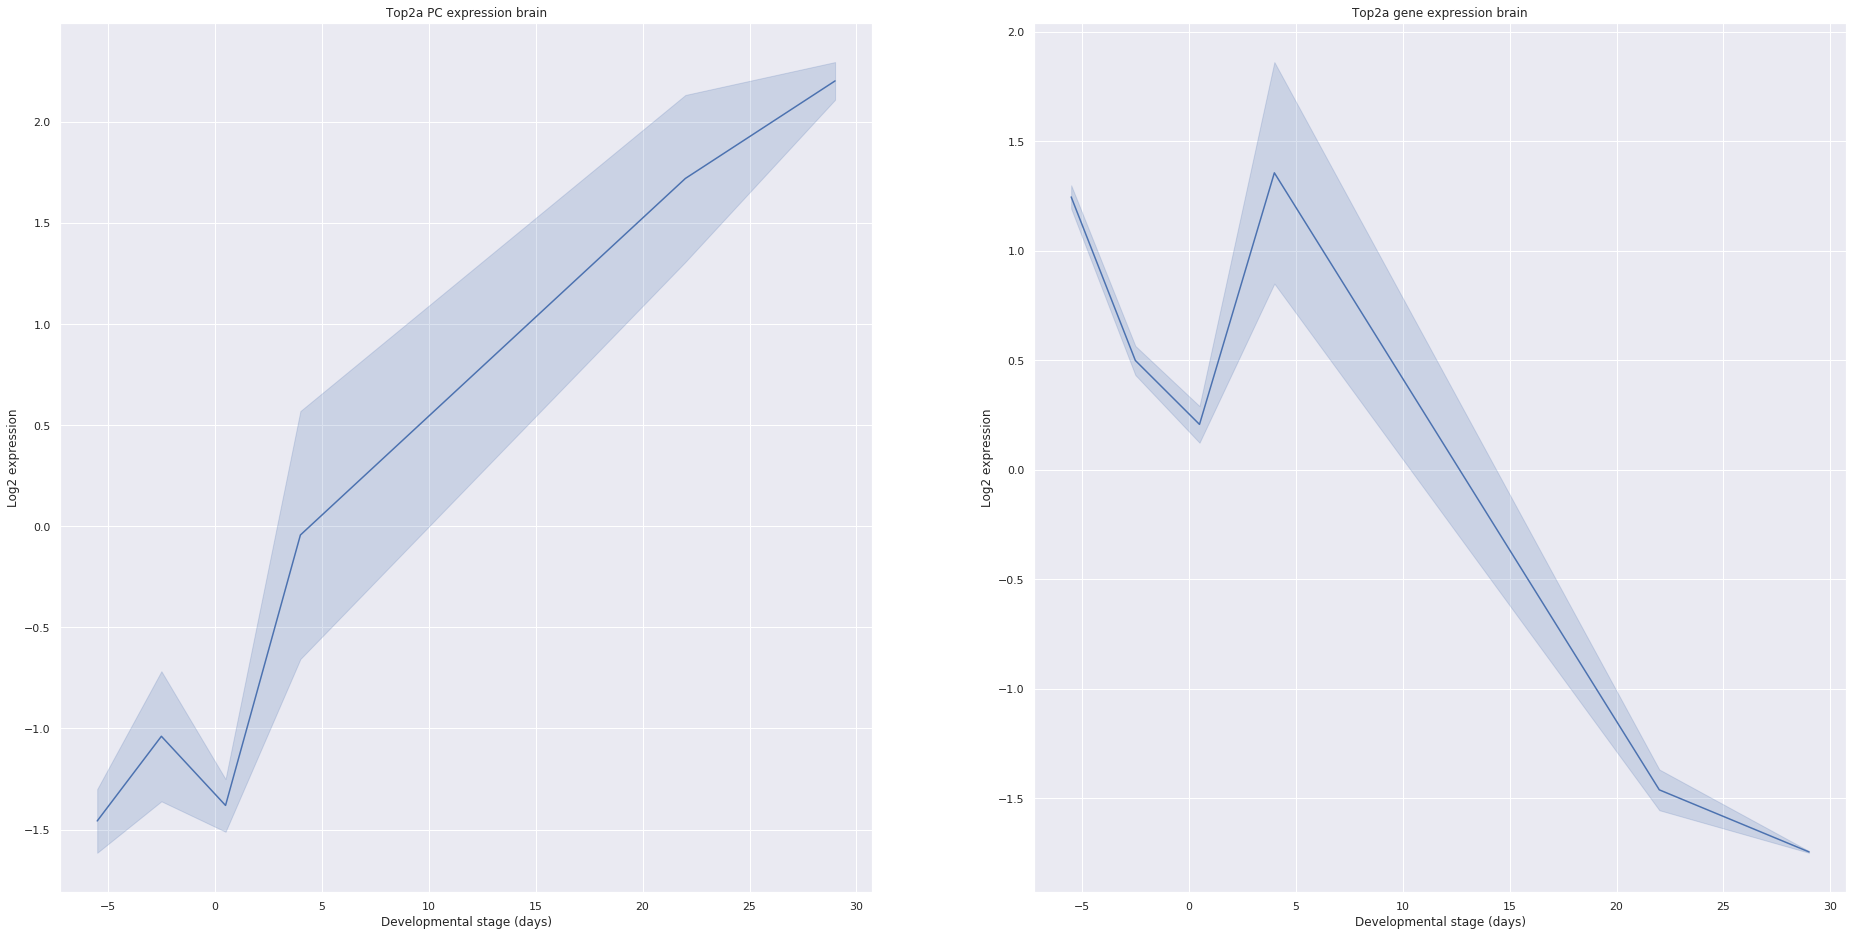

Gene contributions for TF Sox11:


PC1 contribution  PC2 contribution  PC3 contribution
Hnrnpab          0.018980          0.000916      6.080100e-07
Mex3d            0.018804          0.000177      1.488909e-03
Smim3            0.018552          0.000984      5.423889e-04
Plcg1            0.018534          0.001741      1.021422e-03
Klf9             0.018422          0.000625      1.082047e-03
...                   ...               ...               ...
Clcn4            0.000300          0.059991      9.827811e-04
Cep95            0.000207          0.020440      1.953179e-02
Xrcc5            0.000127          0.012413      9.678659e-03
Cops6            0.000037          0.015023      1.437985e-02
Polg2            0.000014          0.034501      8.399461e-03

[95 rows x 3 columns]

Variance explained by PC1 for TF Sox11: 


0.5428695697046791

Gene contributions for TF Zfp57:


PC1 contribution  PC2 contribution  PC3 contribution
Trim67            0.090929          0.007362          0.002626
Tmem125           0.090088          0.002877          0.000605
Arhgap10          0.088173          0.013080          0.000049
Lhx9              0.081395          0.024342          0.001707
Polrmt            0.080727          0.002399          0.000020
Habp4             0.076120          0.024115          0.016915
Brox              0.075728          0.010031          0.020964
Dynlt1a           0.073202          0.030795          0.018206
Inpp5f            0.070138          0.022601          0.035919
Cep83             0.061832          0.033066          0.030705
Nap1l5            0.054559          0.027425          0.055348
Fbxw4             0.046619          0.026001          0.015933
Abhd6             0.038759          0.007324          0.000036
Pank4             0.016613          0.153561          0.003846
Tmem181a          0.013811          0.000728          0.172610
Atf7ip2           0.010950          0.005123          0.138252
Greb1             0.009382          0.014659          0.104686
Dcdc2a            0.008343          0.132441          0.000039
Nhlrc1            0.005571          0.113855          0.003194
Aida              0.004500          0.110906          0.063819
Nefm              0.001825          0.162766          0.008709
Txndc11           0.000251          0.053928          0.143276
Nudt22            0.000246          0.003466          0.030646
Dnajc4            0.000239          0.017150          0.131893

Variance explained by PC1 for TF Zfp57: 


0.43492180645432543

Gene contributions for TF Eomes:


PC1 contribution  PC2 contribution  PC3 contribution
Arhgap15               0.025068          0.000013          0.000004
6430548M08Rik          0.024758          0.000080          0.000282
Hexb                   0.024315          0.003022          0.000236
Deptor                 0.023930          0.000002          0.001473
Nwd1                   0.023893          0.000063          0.002500
...                         ...               ...               ...
Nemf                   0.000563          0.034909          0.056142
1700008O03Rik          0.000559          0.001927          0.067975
Aida                   0.000138          0.077661          0.007317
Nin                    0.000138          0.052914          0.029967
Astn2                  0.000078          0.054579          0.007766

[70 rows x 3 columns]

Variance explained by PC1 for TF Eomes: 


0.5656317151107423

Gene contributions for TF Tbr1:


PC1 contribution  PC2 contribution  PC3 contribution
Otulinl            2.191439e-02          0.000056          0.000671
6430548M08Rik      2.180319e-02          0.000015          0.000018
Bpgm               2.139470e-02          0.000004          0.000417
Chl1               2.135471e-02          0.002059          0.000267
Hgsnat             2.128937e-02          0.001284          0.000002
...                         ...               ...               ...
Txndc11            5.835219e-04          0.056897          0.029289
1700008O03Rik      2.843113e-04          0.048212          0.002530
Lag3               1.406387e-04          0.030920          0.028891
Aida               1.703874e-05          0.012555          0.079756
Nin                8.057201e-07          0.027875          0.019385

[81 rows x 3 columns]

Variance explained by PC1 for TF Tbr1: 


0.5524894034100718

Gene contributions for TF Satb2:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125      2.845044e-02          0.000393          0.000872
Hexb         2.757295e-02          0.003574          0.001650
Cbr1         2.746595e-02          0.000718          0.002235
Pcdh20       2.731657e-02          0.001126          0.001348
Ndufs1       2.714886e-02          0.000215          0.005357
...                   ...               ...               ...
Ube2m        1.517162e-04          0.055700          0.001753
Dcdc2a       4.035731e-05          0.044699          0.003055
Txndc11      3.913823e-05          0.001431          0.084272
Crebzf       3.381460e-05          0.050019          0.006040
Aida         1.347332e-07          0.060365          0.003333

[71 rows x 3 columns]

Variance explained by PC1 for TF Satb2: 


0.4755390805053634

Gene contributions for TF Sox4:


PC1 contribution  PC2 contribution  PC3 contribution
Hnrnpab                0.019740          0.000490          0.000081
Rbm4b                  0.019408          0.000900          0.000855
Rbm15b                 0.019275          0.000461          0.001950
Yeats2                 0.019045          0.002637          0.000081
Hnrnph1                0.018976          0.000082          0.001158
...                         ...               ...               ...
Oga                    0.000105          0.059560          0.002080
Cep95                  0.000058          0.008607          0.036634
Polg2                  0.000020          0.034449          0.000115
Cops6                  0.000020          0.017118          0.002276
0610009B22Rik          0.000006          0.022200          0.045339

[92 rows x 3 columns]

Variance explained by PC1 for TF Sox4: 


0.5409516347989272

Gene contributions for TF Dlx1:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125          0.145673          0.000086          0.004090
Kpna1            0.129084          0.006483          0.015315
Eef2             0.126204          0.012367          0.049626
Il31ra           0.113114          0.000162          0.020344
Brox             0.094088          0.001251          0.074696
Pknox1           0.093576          0.030625          0.016094
Dapk3            0.077086          0.001530          0.143677
Fbxw4            0.076287          0.052907          0.038427
Pisd             0.063152          0.013117          0.136174
Abca3            0.033661          0.207231          0.000450
Abca17           0.029365          0.185588          0.001110
Tmem18           0.018675          0.213639          0.001123
Txndc11          0.000020          0.153221          0.254047
Aida             0.000015          0.121794          0.244828

Variance explained by PC1 for TF Dlx1: 


0.4758946686577553

Gene contributions for TF Lhx6:


PC1 contribution  PC2 contribution  PC3 contribution
Usp42            0.022629          0.000060          0.000199
Bahcc1           0.022350          0.000634          0.000424
Tubb5            0.022131          0.002212          0.001831
Hgsnat           0.022040          0.000824          0.000007
Gpc2             0.021913          0.001219          0.004437
...                   ...               ...               ...
Greb1            0.001831          0.030408          0.017281
Txndc11          0.000451          0.029769          0.032899
Zfp143           0.000022          0.057245          0.016949
Aida             0.000006          0.024779          0.064553
Stap2            0.000002          0.006771          0.070228

[81 rows x 3 columns]

Variance explained by PC1 for TF Lhx6: 


0.5263113191978195

Gene contributions for TF Isl1:


PC1 contribution  PC2 contribution  PC3 contribution
Cbx6             0.024566          0.000117          0.000001
Ppp1r9b          0.024290          0.000290          0.001376
Tjp3             0.023603          0.003139          0.000454
Nfe2             0.023181          0.000277          0.006649
Abhd16a          0.022790          0.000019          0.000263
...                   ...               ...               ...
Rnf207           0.000042          0.000961          0.046318
Bmf              0.000018          0.000574          0.058987
Rnft2            0.000010          0.034358          0.016648
Dcaf4            0.000009          0.011839          0.011519
Aida             0.000009          0.015342          0.069205

[80 rows x 3 columns]

Variance explained by PC1 for TF Isl1: 


0.4978397395048787

Gene contributions for TF Top2a:


PC1 contribution  PC2 contribution  PC3 contribution
Sspn             0.348690          0.079374          0.021344
Brox             0.335413          0.016206          0.082386
Kpna1            0.296070          0.122503          0.081932
Aida             0.019810          0.460315          0.312479
Txndc11          0.000017          0.321603          0.501860

Variance explained by PC1 for TF Top2a: 


0.45354050639301036

In [16]:
#PCA 1 & 2 removed
[a,b,c] = main2(10,MACS2=300,MAX=100,n_pc=3,PC=1,organ='brain',which='Top')

Here we go...
Done
(16984, 24)


(12, 95)

(12, 5)

(12, 24)

(12, 53)

(12, 92)

(12, 54)

(12, 71)

(12, 79)

(12, 84)

(12, 81)

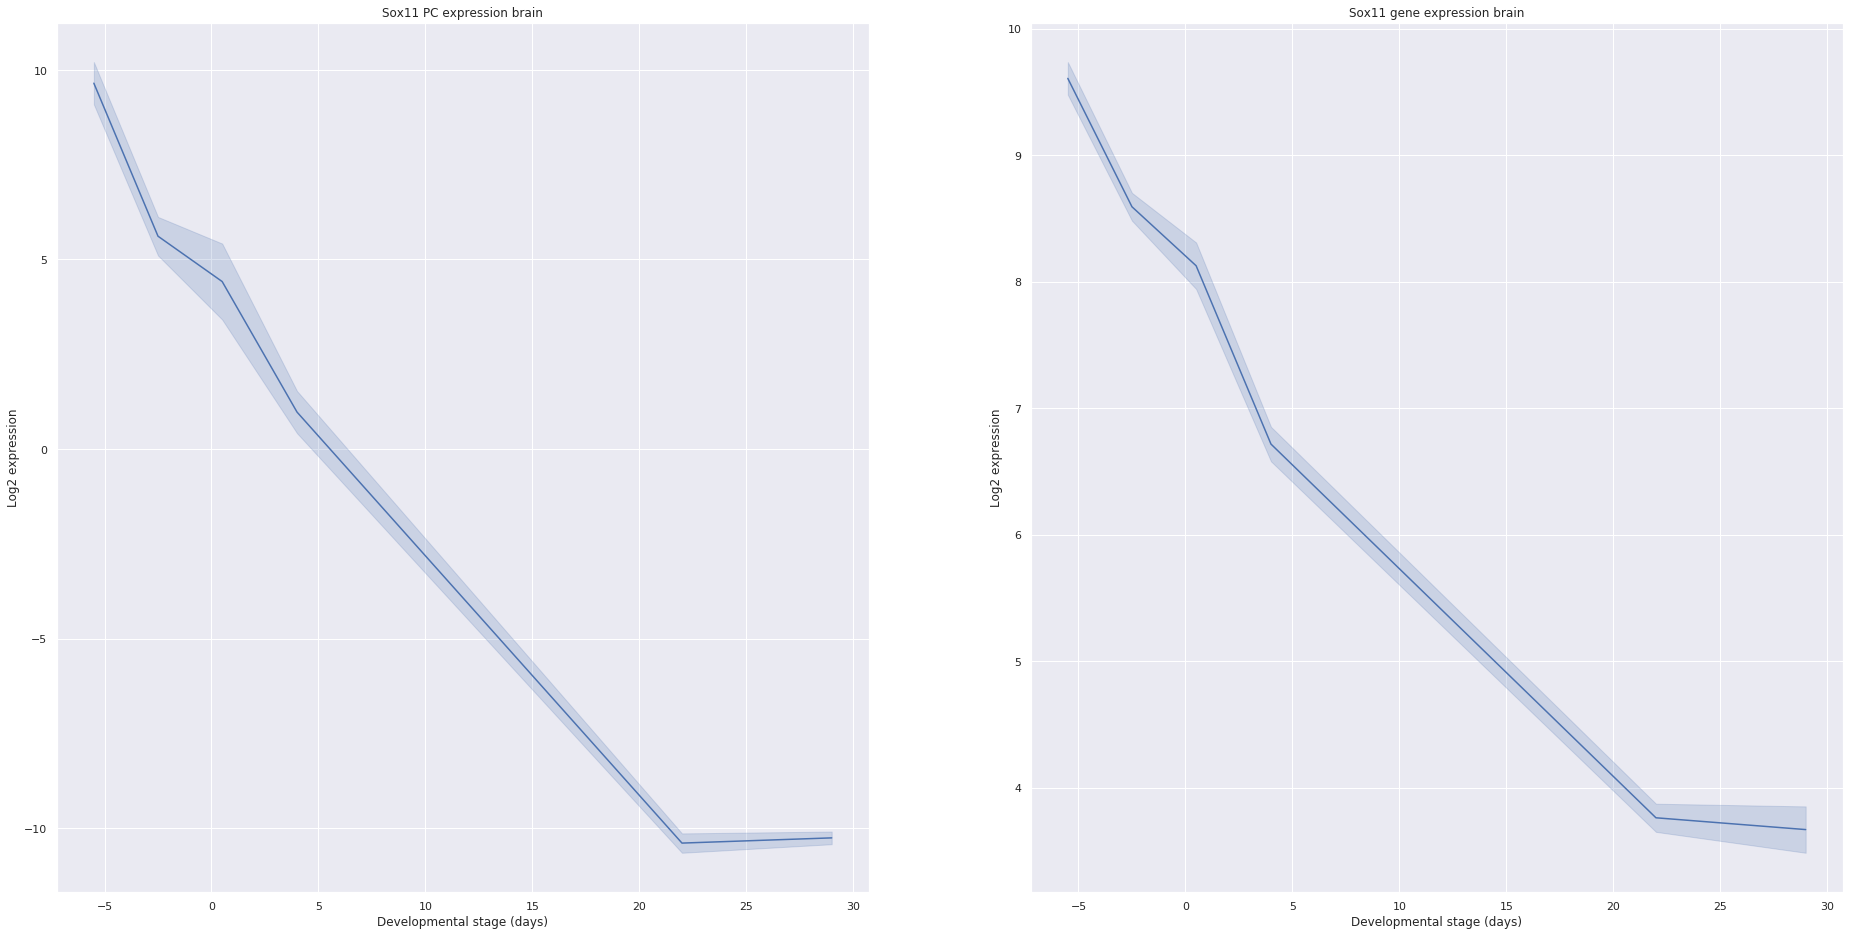

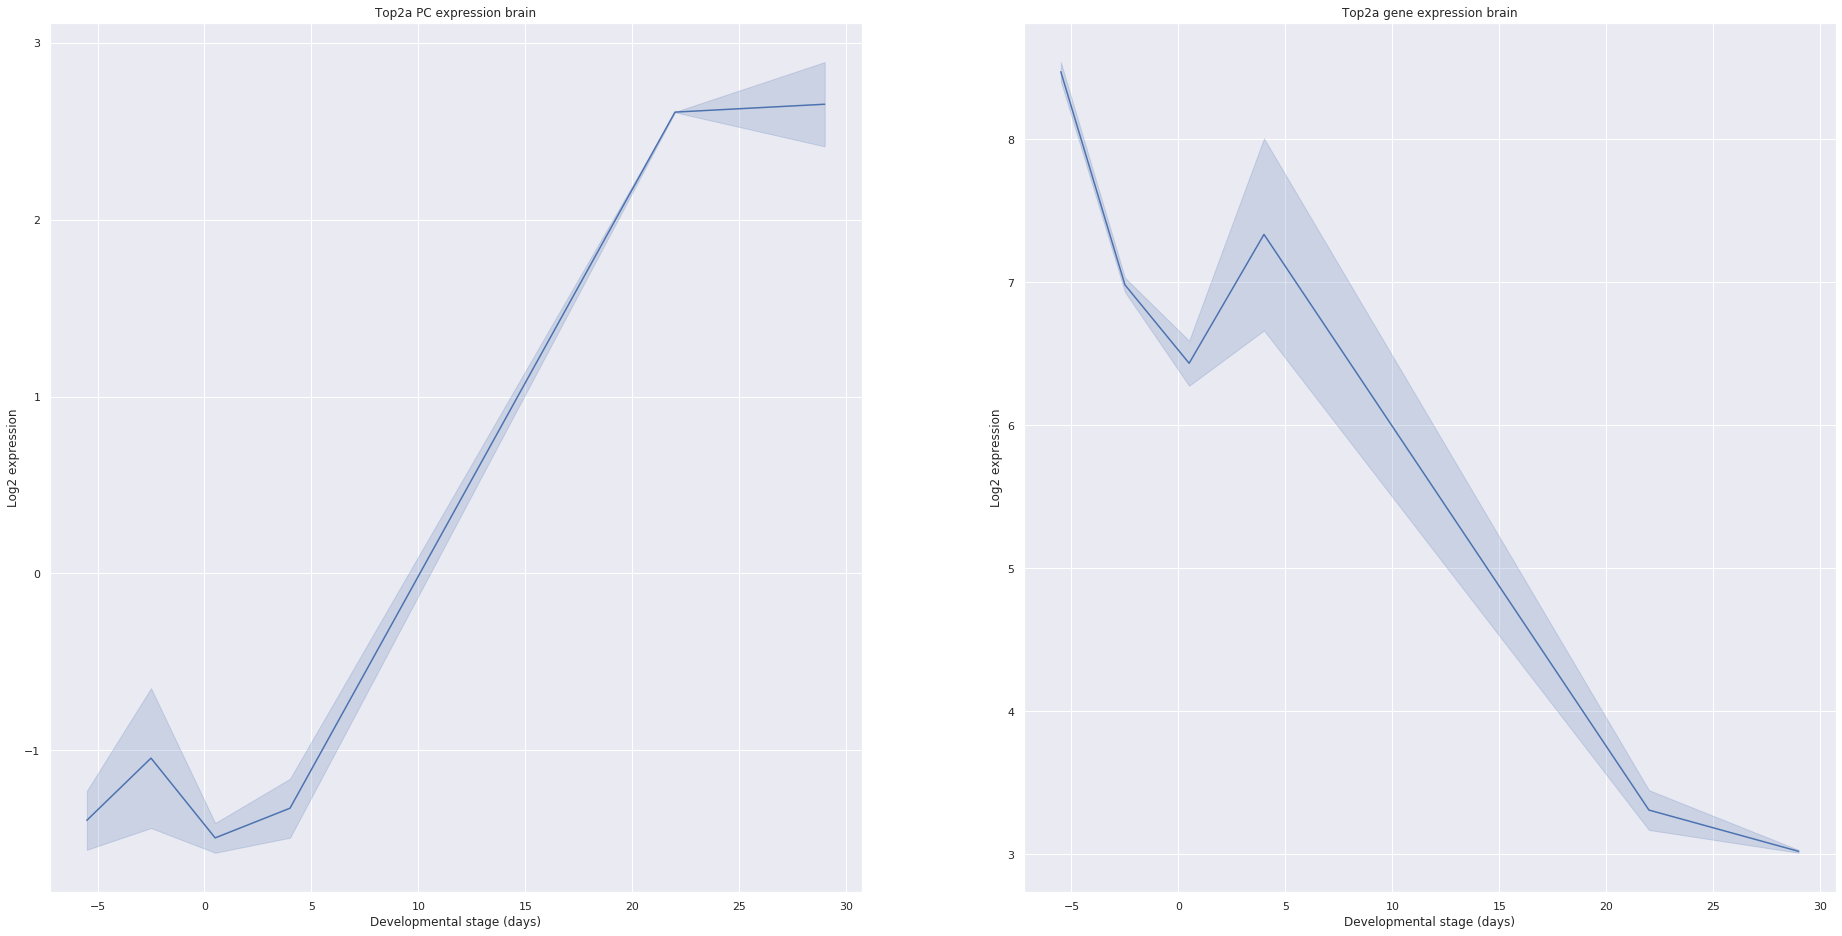

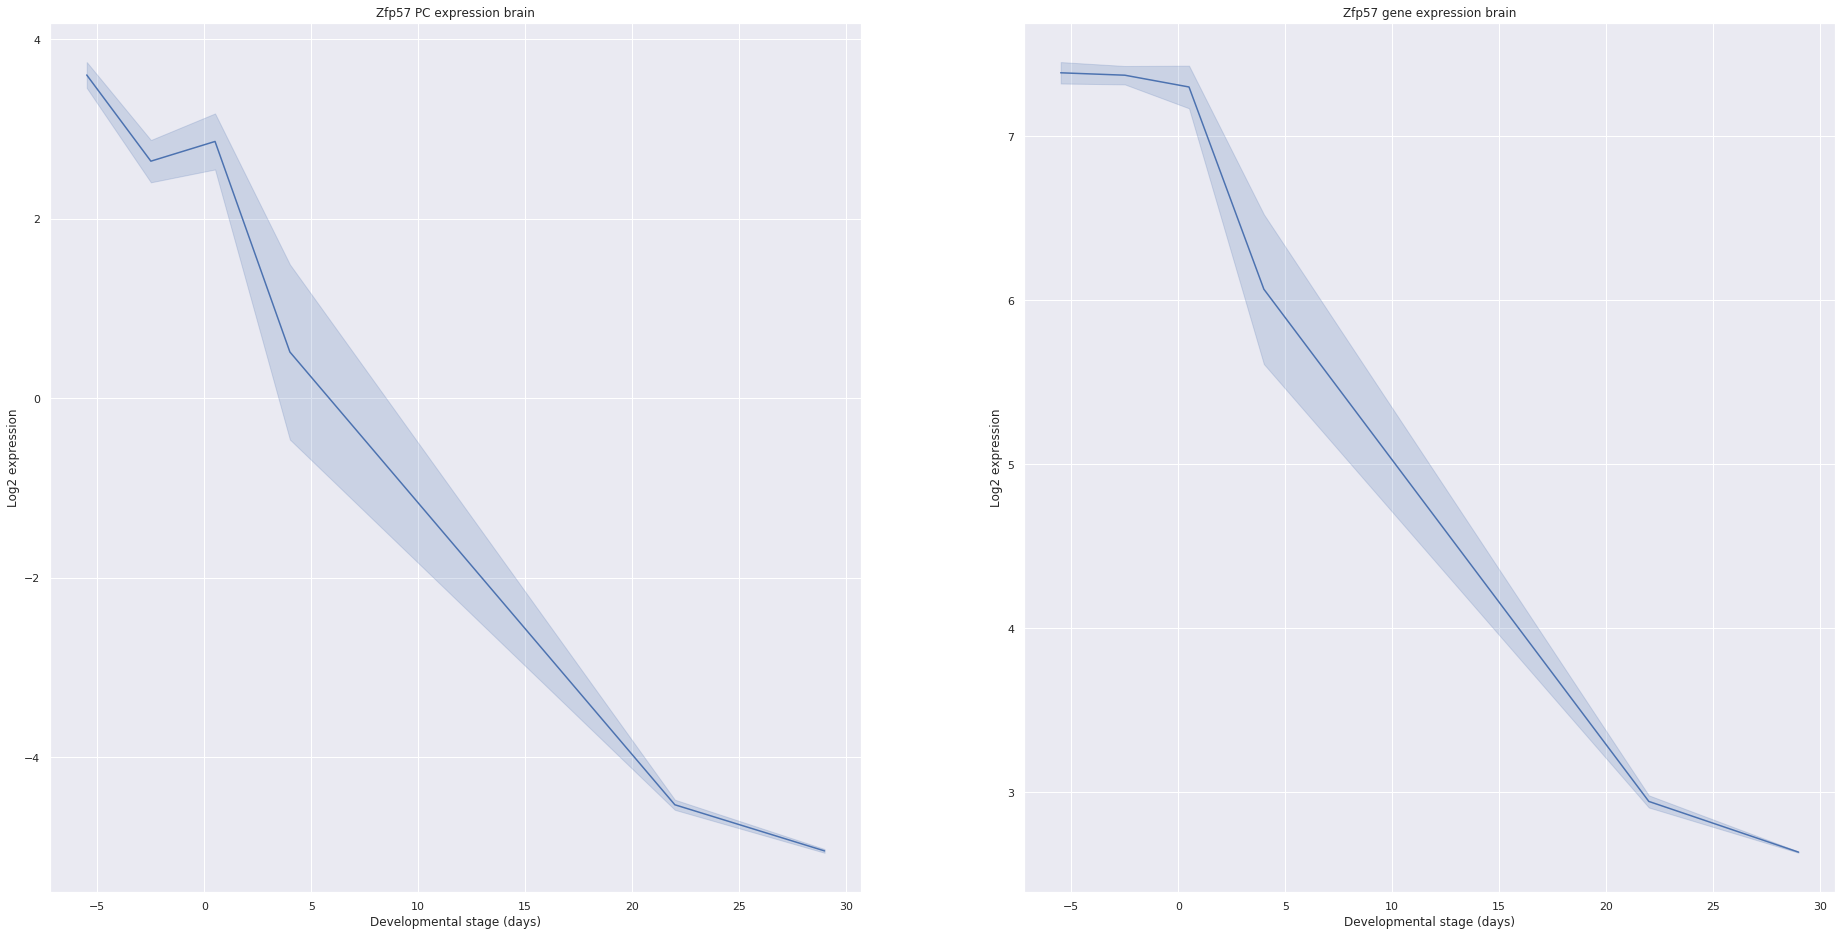

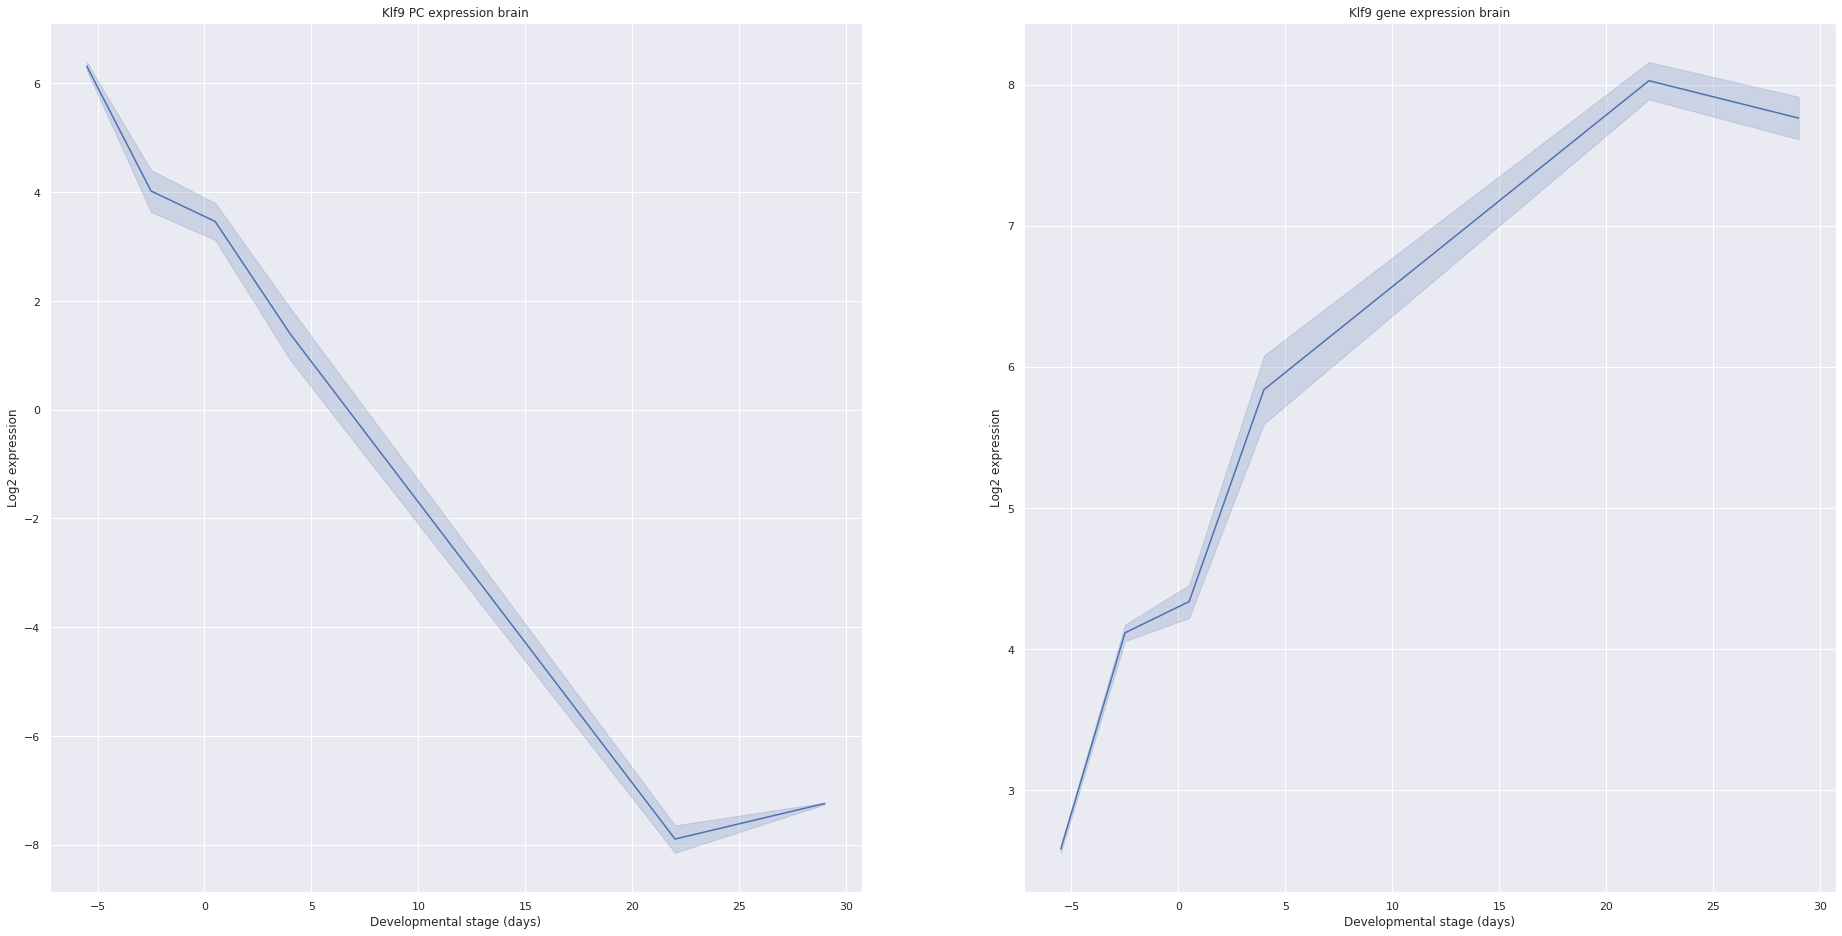

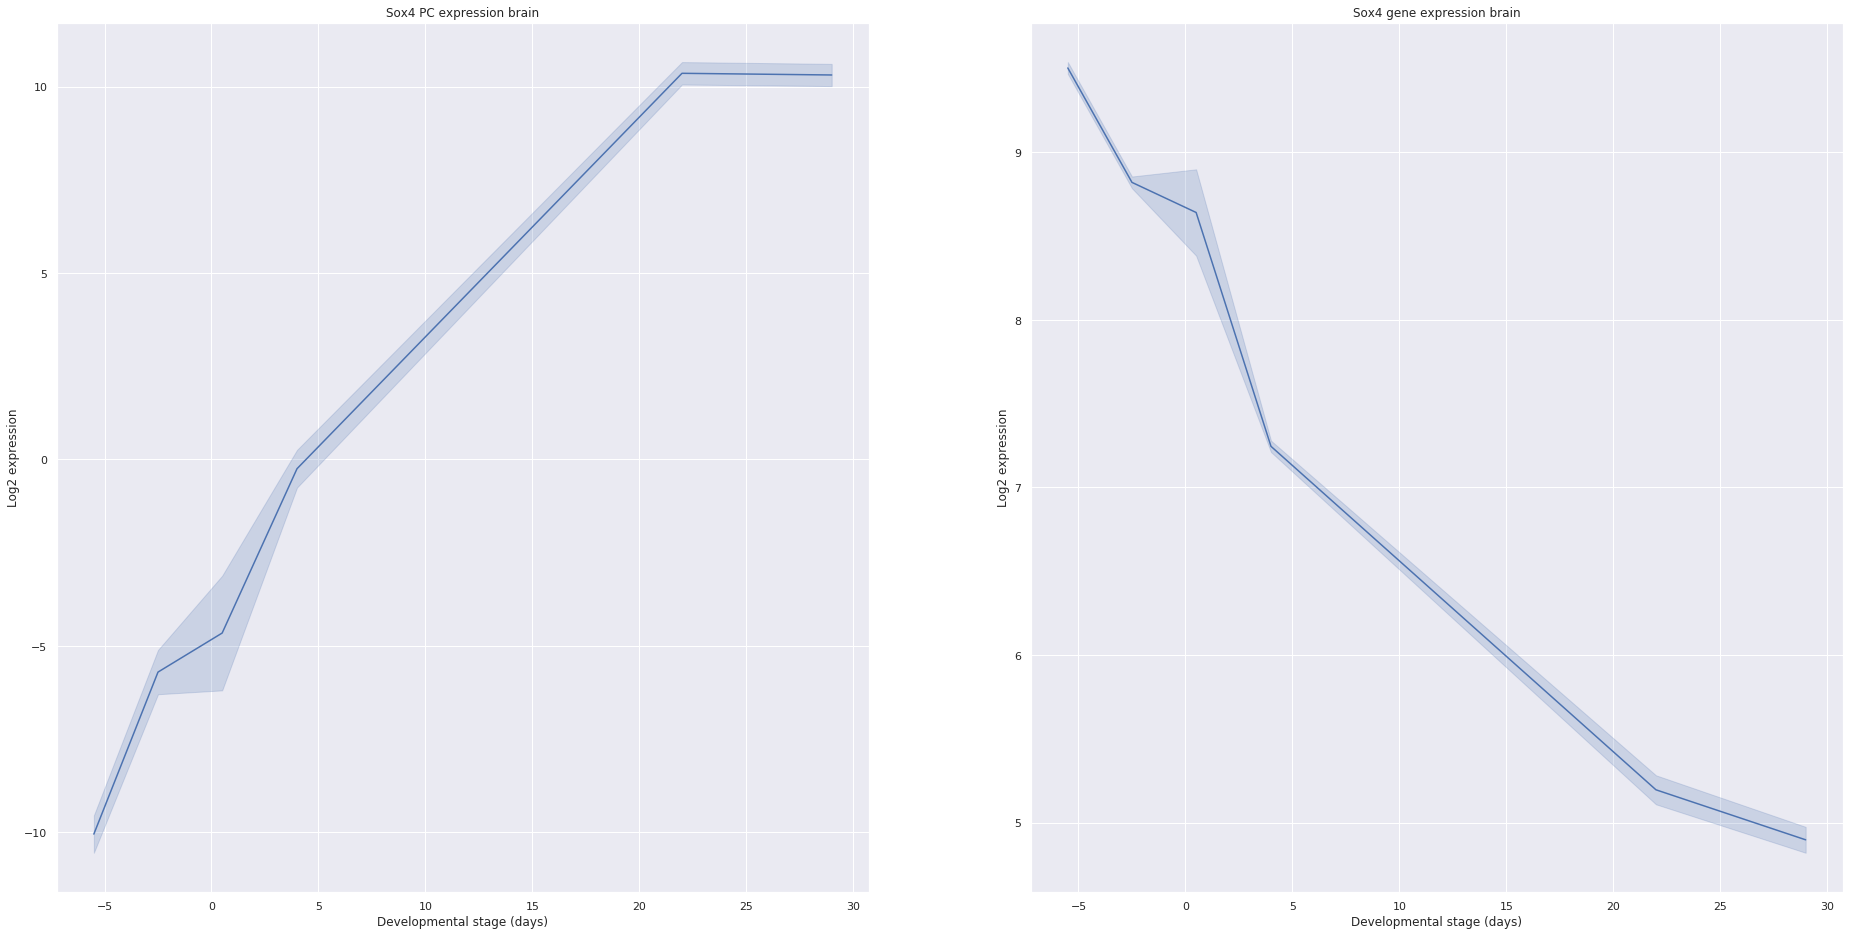

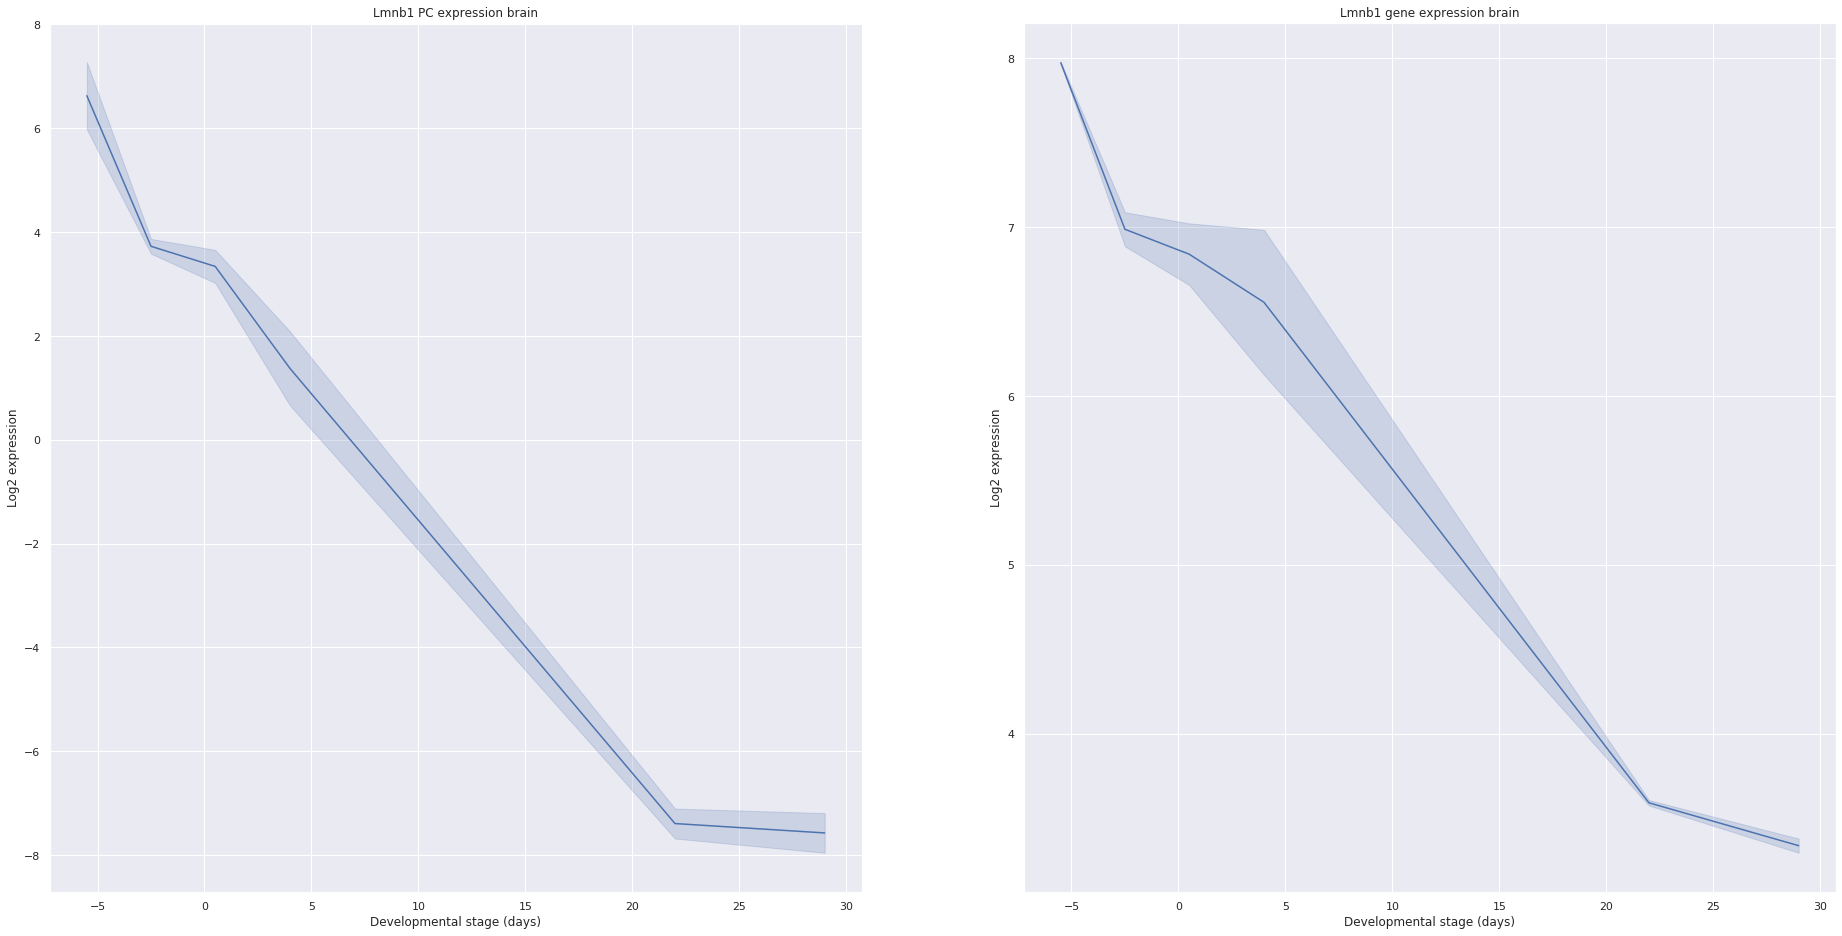

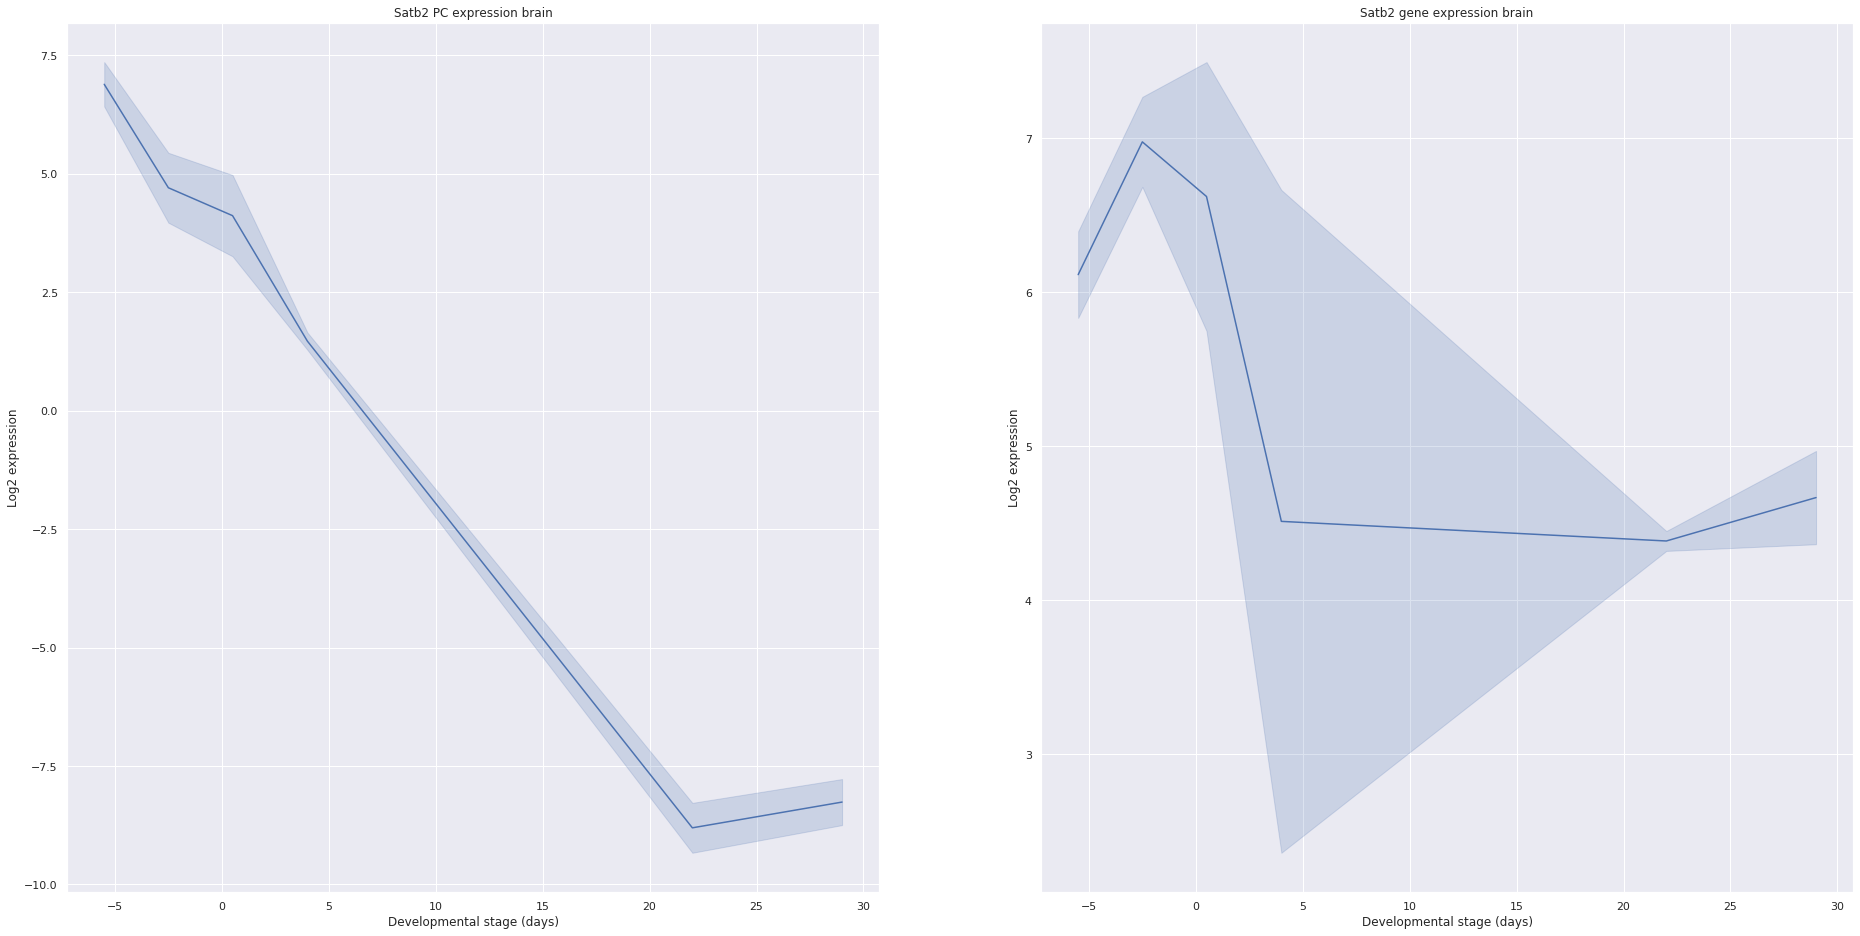

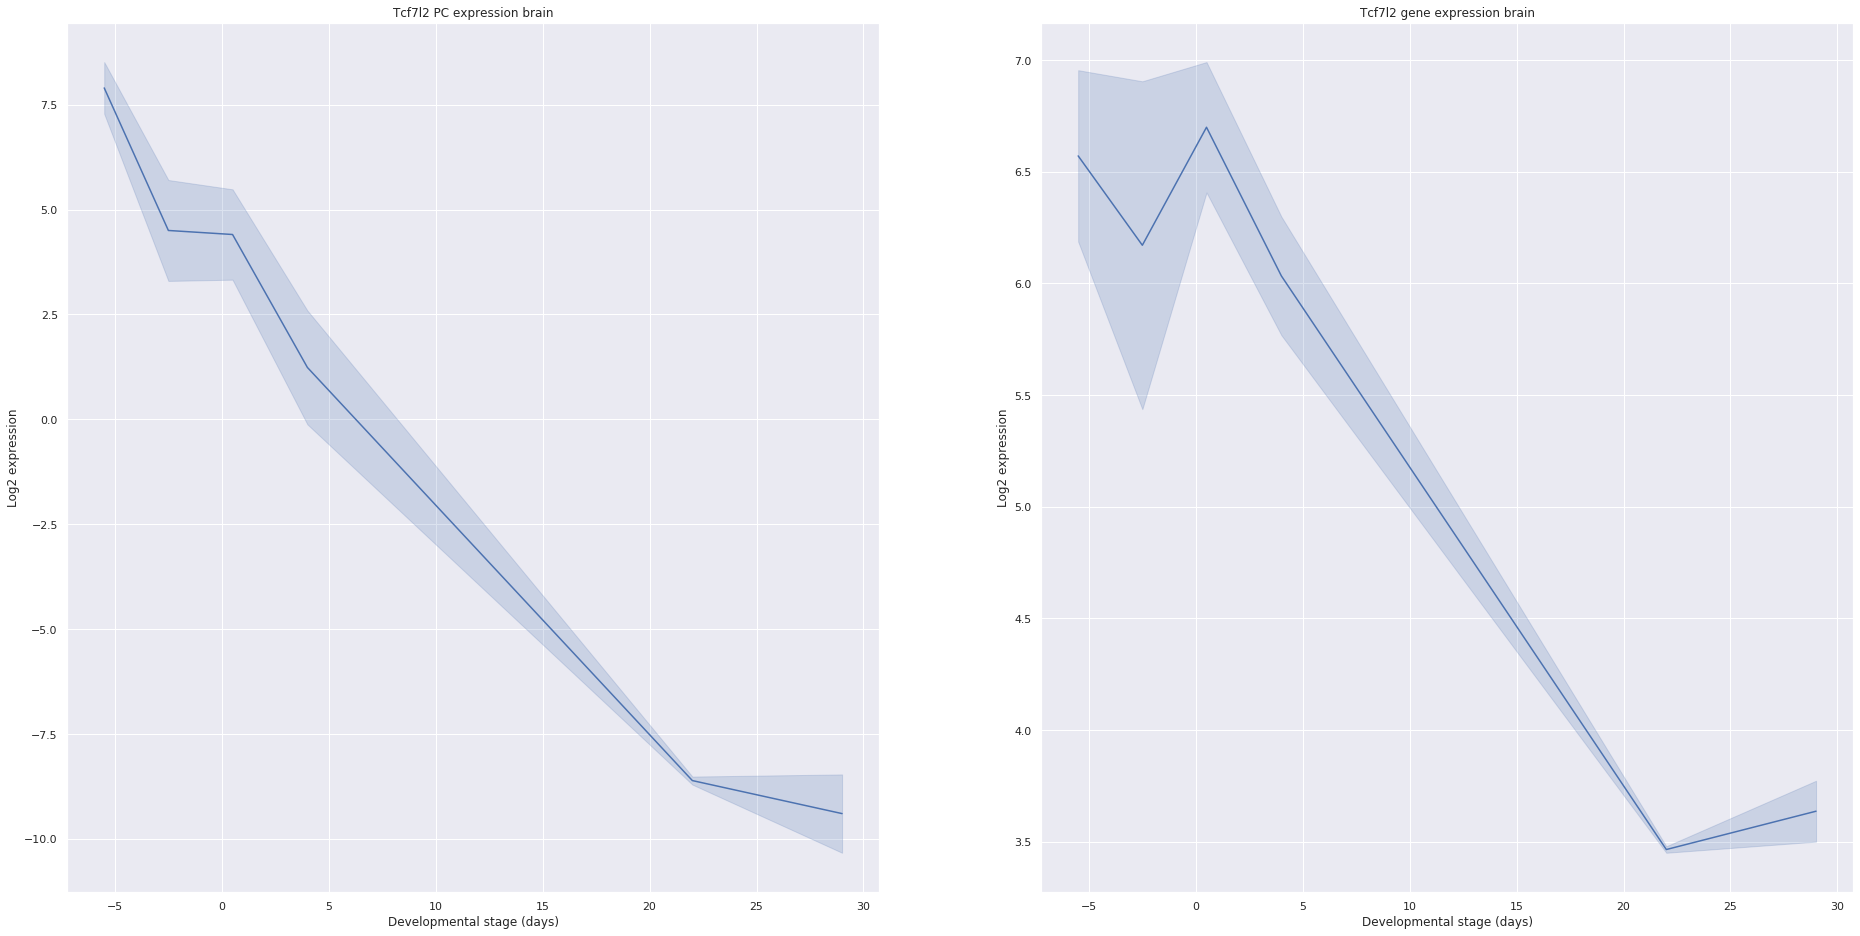

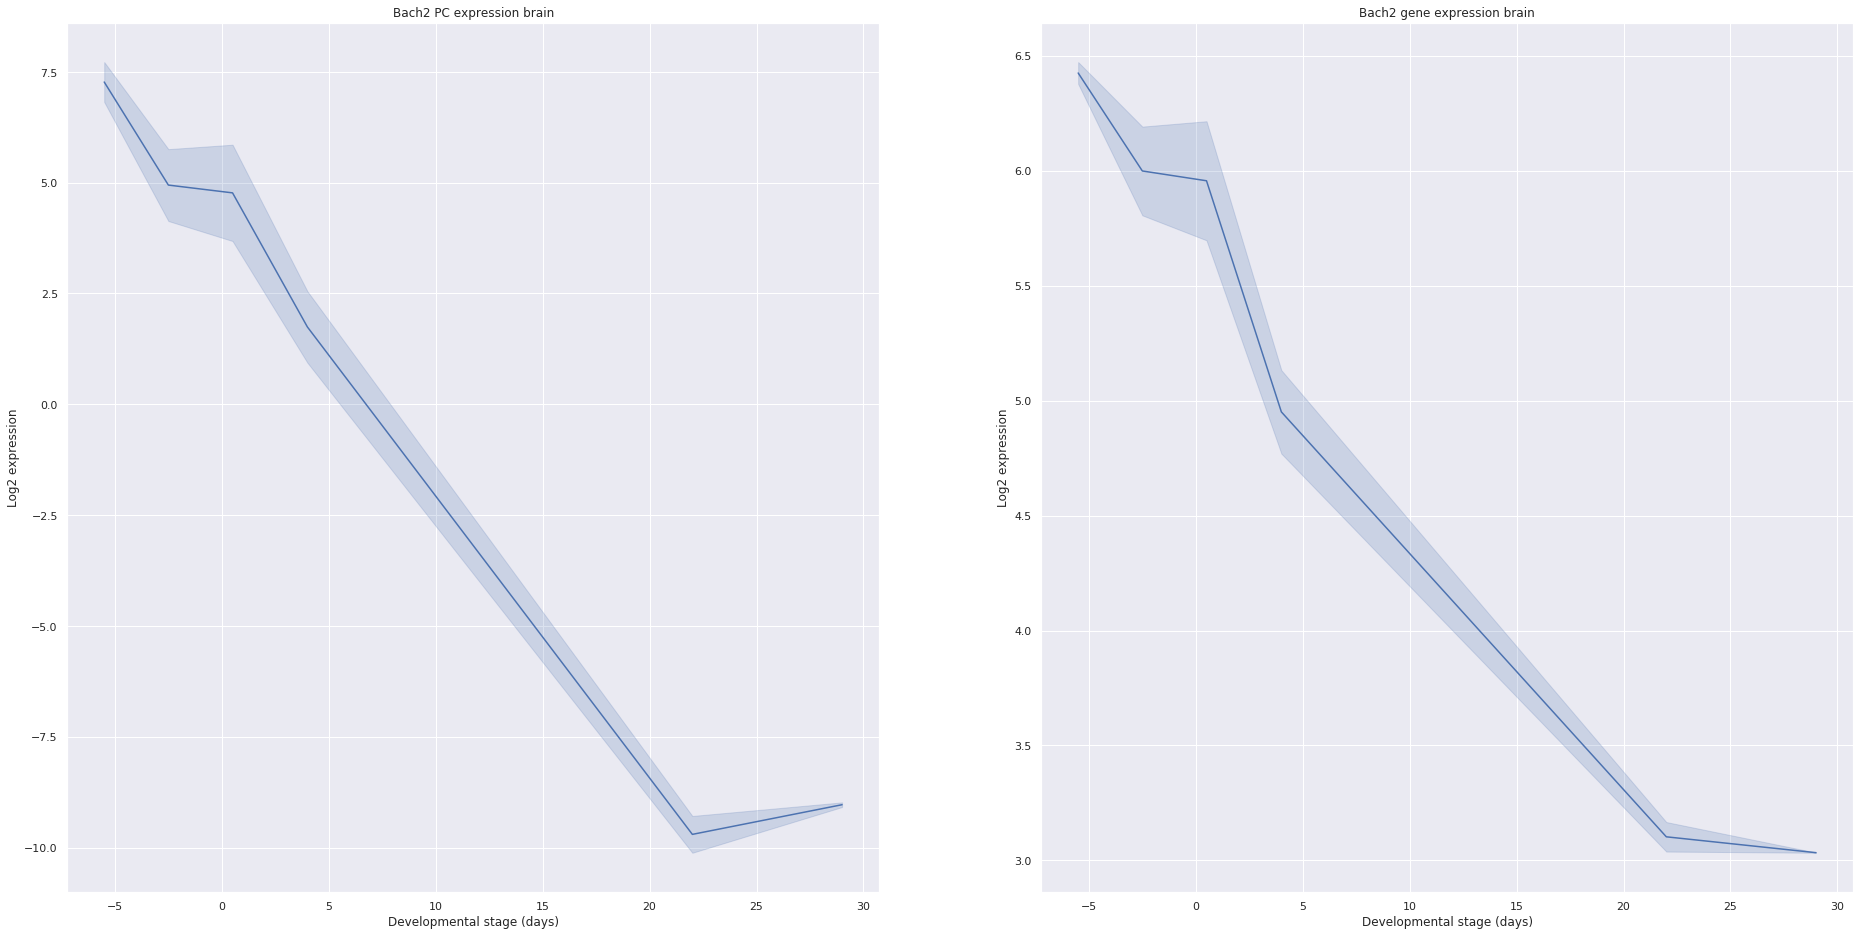

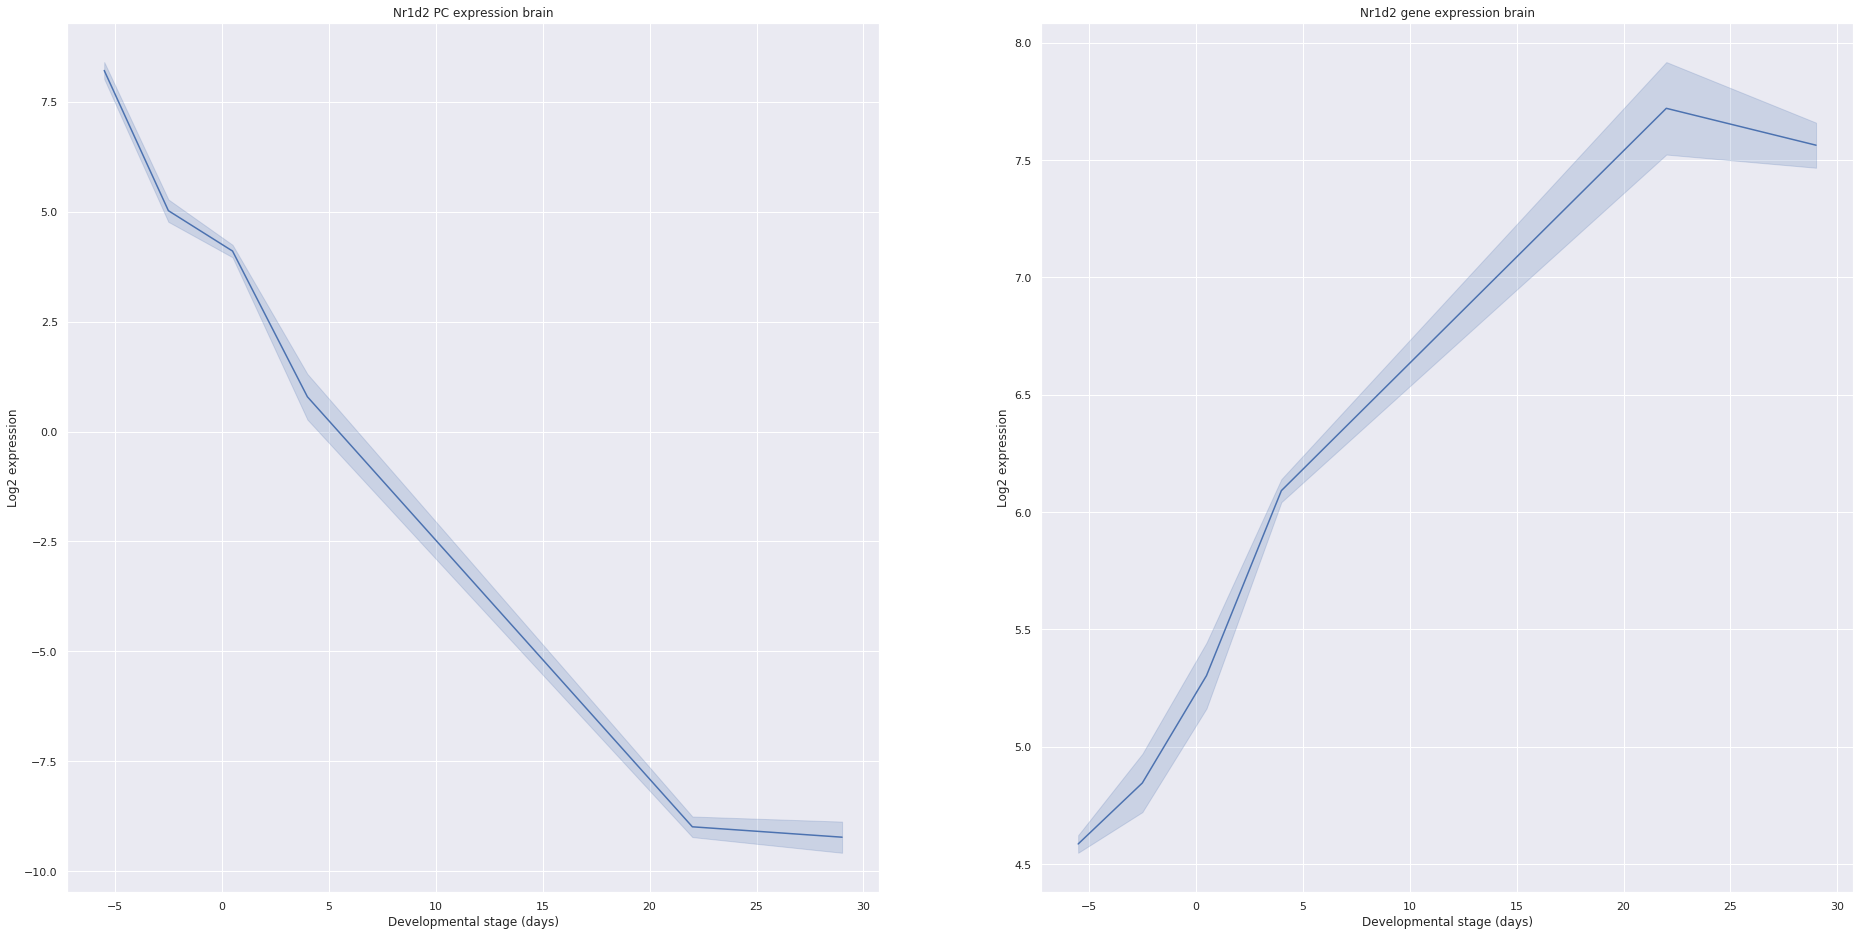

Gene contributions for TF Sox11:


PC1 contribution  PC2 contribution  PC3 contribution
Hnrnpab      1.647192e-02          0.000355          0.000281
Xrn2         1.620489e-02          0.000150          0.000082
Smarce1      1.611992e-02          0.000323          0.002941
Rfc3         1.609752e-02          0.000038          0.000253
Mcm7         1.608222e-02          0.000228          0.001057
...                   ...               ...               ...
Phykpl       2.984041e-04          0.073808          0.000565
Xrcc5        5.076529e-05          0.014681          0.067317
Tecr         3.749614e-05          0.023740          0.070487
Manbal       3.424324e-05          0.002059          0.097932
Hus1         2.946282e-07          0.038501          0.001556

[95 rows x 3 columns]

Variance explained by PC1 for TF Sox11: 


0.6320015093427309

Gene contributions for TF Top2a:


PC1 contribution  PC2 contribution  PC3 contribution
Brox             0.234524          0.064258          0.067999
Kpna1            0.231288          0.080334          0.156444
Aida             0.208773          0.300309          0.061892
Sspn             0.172659          0.003978          0.584987
Txndc11          0.152756          0.551121          0.128678

Variance explained by PC1 for TF Top2a: 


0.7046250261512486

Gene contributions for TF Zfp57:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125           0.082790          0.002286          0.001437
Arhgap10          0.074709          0.002311          0.005213
Trim67            0.074518          0.000294          0.012631
Lhx9              0.073412          0.010256          0.001373
Abhd6             0.069902          0.000417          0.010586
Brox              0.069555          0.007128          0.009499
Dynlt1a           0.068669          0.008202          0.024801
Habp4             0.067921          0.007906          0.026749
Inpp5f            0.058276          0.003770          0.076638
Greb1             0.055235          0.000061          0.053435
Nap1l5            0.046910          0.011109          0.115143
Aida              0.043519          0.055947          0.036647
Polrmt            0.040204          0.039285          0.013051
Txndc11           0.034039          0.046771          0.055395
Fbxw4             0.028762          0.028434          0.025421
Tmem181a          0.020341          0.000671          0.178051
Atf7ip2           0.019088          0.003470          0.081957
Dnajc4            0.016140          0.011628          0.062262
Nudt22            0.014809          0.000028          0.040526
Nhlrc1            0.014092          0.132251          0.030077
Pank4             0.012433          0.157316          0.011041
Dcdc2a            0.005961          0.130725          0.029391
Nefm              0.004796          0.181820          0.023400
Cep83             0.003921          0.157912          0.075276

Variance explained by PC1 for TF Zfp57: 


0.5280899894214832

Gene contributions for TF Klf9:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125            0.033122          0.000306          0.000303
Smarcb1            0.031523          0.000008          0.000131
Hexb               0.030922          0.000296          0.000933
Arhgap28           0.030711          0.000053          0.001030
Dcakd              0.030415          0.000005          0.007844
Ilrun              0.030345          0.000455          0.005626
Casp3              0.030048          0.005305          0.001142
Riok1              0.029936          0.006696          0.000702
Prmt2              0.029905          0.006144          0.002728
D11Wsu47e          0.029619          0.000416          0.000591
Nectin2            0.029348          0.008992          0.000075
Smpd4              0.029215          0.000028          0.003703
Ccdc90b            0.029016          0.004517          0.003326
Anapc7             0.028773          0.008334          0.003355
Lcat               0.027800          0.002536          0.009985
Rpl37rt            0.026969          0.009886          0.000968
Klf13              0.026660          0.016694          0.004179
Xrcc6              0.026304          0.012046          0.000139
Spata5             0.026199          0.004268          0.003087
Armc7              0.025931          0.000281          0.012796
Brox               0.025305          0.011694          0.000797
Ctrl               0.024269          0.012877          0.004304
Kpna1              0.021628          0.007723          0.012896
Desi1              0.021535          0.001559          0.031578
Aida               0.020072          0.002281          0.041700
Smyd5              0.019301          0.044216          0.000008
Psmb10             0.019261          0.049755          0.000724
Unc50              0.018170          0.000026          0.064211
Sccpdh             0.017582          0.028128          0.012201
Anxa2              0.017374          0.019778          0.003643
Rnf44              0.017324          0.026247          0.035372
Mbd6               0.016436          0.008190          0.067183
Pole4              0.016417          0.061001          0.002342
Hist1h4n           0.016216          0.016344          0.041738
Hist1h4m           0.015972          0.014486          0.042036
Ndrg1              0.015790          0.000029          0.000006
Txndc11            0.012997          0.047153          0.028848
Fam13b             0.012759          0.019524          0.050309
Arid4a             0.012452          0.022415          0.054887
Fam104a            0.010758          0.041488          0.023463
Tfip11             0.010421          0.008584          0.031652
Acads              0.010040          0.008780          0.016518
Slc6a9             0.009523          0.049125          0.043208
Fbxw8              0.007999          0.004139          0.101437
Lrr1               0.007877          0.070293          0.021320
Rps29              0.006483          0.030626          0.040842
Zfp622             0.004551          0.002522          0.121486
Ctdsp2             0.004500          0.089060          0.001647
Coa5               0.003645          0.074398          0.000010
Agl                0.000272          0.001064          0.002185
Cage1              0.000220          0.011475          0.004449
Nudt6              0.000069          0.044165          0.030282
Cdhr2              0.000019          0.083590          0.004075

Variance explained by PC1 for TF Klf9: 


0.5851459209759846

Gene contributions for TF Sox4:


PC1 contribution  PC2 contribution  PC3 contribution
Hnrnpab                0.015955          0.000219          0.000104
Hnrnph1                0.015852          0.000029          0.000771
Rbm15b                 0.015787          0.000057          0.001685
Smchd1                 0.015777          0.000483          0.000010
Yeats2                 0.015728          0.001585          0.000439
...                         ...               ...               ...
Phykpl                 0.000314          0.070382          0.020082
Ccni                   0.000307          0.005845          0.073301
Hyal1                  0.000038          0.010325          0.063977
1190007I07Rik          0.000027          0.000039          0.012941
Rnaseh2a               0.000008          0.066411          0.000088

[92 rows x 3 columns]

Variance explained by PC1 for TF Sox4: 


0.6744571688574345

Gene contributions for TF Lmnb1:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125            0.032793          0.003238      1.691686e-04
Actb               0.031515          0.000240      3.832886e-06
Osbpl1a            0.030898          0.002529      4.942942e-04
Hexb               0.030810          0.000004      6.154032e-03
Cenpu              0.030205          0.000003      5.351231e-03
Arhgap10           0.029738          0.003481      2.266115e-04
Eef1a1             0.029265          0.000852      1.113099e-02
Cerk               0.028309          0.004147      7.380977e-03
H3c6               0.027925          0.000005      1.040068e-03
Eif4enif1          0.027902          0.002732      1.077776e-02
Abhd6              0.027757          0.002336      6.429751e-03
Cbr1               0.027480          0.001092      9.599143e-03
H2bc6              0.026978          0.000004      1.515482e-03
Actg1              0.026943          0.019607      4.099556e-07
Pknox1             0.026801          0.004723      5.971279e-03
Prdm15             0.026597          0.000997      1.110438e-02
Csf2ra             0.026511          0.005892      3.752650e-03
Fbxl18             0.026001          0.019435      2.709319e-03
Sspn               0.025931          0.009872      8.146288e-03
H1f3               0.025840          0.001847      2.656218e-05
Pald1              0.025133          0.018356      1.341601e-03
Sfi1               0.024670          0.006795      1.312666e-02
Brox               0.024315          0.007964      8.361099e-03
Greb1              0.024257          0.005030      1.188739e-02
Tecpr1             0.024240          0.002798      3.367556e-02
Kpna1              0.021353          0.013835      2.171455e-02
Mylip              0.020953          0.021943      3.104475e-03
Aida               0.020899          0.005194      4.814865e-02
Wwox               0.020817          0.005374      2.965387e-02
Kansl3             0.020663          0.005162      2.318467e-02
Setd4              0.019991          0.004189      5.003274e-02
H4c6               0.019122          0.001242      6.297708e-03
Acta1              0.017906          0.038116      1.602267e-04
Il31ra             0.017822          0.001128      1.015308e-03
H1f4               0.017797          0.024964      2.856882e-02
Col6a6             0.017618          0.023249      2.007942e-02
Nemf               0.015414          0.028716      4.610825e-02
Zfp143             0.014086          0.067825      3.376344e-04
Fbxw4              0.012408          0.021039      1.977477e-03
Clec4n             0.011405          0.005802      1.781607e-04
Lrr1               0.010802          0.057182      3.849352e-02
Txndc11            0.010525          0.058625      2.213749e-02
Fer1l5             0.006351          0.024350      3.351746e-02
Rps29              0.004626          0.043700      2.575334e-02
Oasl1              0.004202          0.002283      1.021917e-03
Def8               0.001682          0.079161      6.760170e-04
Abca17             0.001422          0.087893      3.089700e-02
Acacb              0.001118          0.001921      2.341521e-02
Aldh9a1            0.001013          0.036205      4.128243e-02
Dcdc2a             0.000695          0.000113      1.341798e-01
Sympk              0.000354          0.088229      8.978082e-03
Dtwd1              0.000087          0.001640      1.570723e-01
Abca3              0.000045          0.095916      1.891739e-02
Zfp949             0.000012          0.031027      2.271960e-02

Variance explained by PC1 for TF Lmnb1: 


0.5735095618814298

Gene contributions for TF Satb2:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125      2.594161e-02          0.000209          0.000869
Hexb         2.428322e-02          0.002512          0.000560
Ndufs1       2.423307e-02          0.000066          0.001758
Acin1        2.361254e-02          0.000030          0.006459
Osbpl1a      2.344022e-02          0.002939          0.000973
...                   ...               ...               ...
Tgm4         4.718408e-04          0.014629          0.035320
Aldh9a1      4.151117e-04          0.055154          0.000347
Pigyl        1.014464e-04          0.019143          0.066411
Ccdc106      8.127885e-05          0.043321          0.036967
Abca3        7.579621e-10          0.061024          0.029980

[71 rows x 3 columns]

Variance explained by PC1 for TF Satb2: 


0.5577843284585305

Gene contributions for TF Tcf7l2:


PC1 contribution  PC2 contribution  PC3 contribution
Tmem125           0.022023          0.003242          0.000288
Ephb2             0.021495          0.001538          0.000031
Sike1             0.021192          0.001089          0.000050
Osbpl1a           0.020881          0.000146          0.002220
Zfp503            0.020781          0.001775          0.000982
...                    ...               ...               ...
Dtwd1             0.000179          0.014851          0.093208
Izumo1            0.000117          0.007462          0.035274
BC016579          0.000086          0.002962          0.030777
Zfp949            0.000068          0.001930          0.021454
Timmdc1           0.000001          0.004666          0.058275

[79 rows x 3 columns]

Variance explained by PC1 for TF Tcf7l2: 


0.5756378009427325

Gene contributions for TF Bach2:


PC1 contribution  PC2 contribution  PC3 contribution
Lrp8         2.103300e-02          0.000130          0.000376
Ap1g1        2.099912e-02          0.000175          0.000015
Midn         2.072884e-02          0.001110          0.001069
Smarca4      2.071929e-02          0.000379          0.002091
Cbx6         2.067036e-02          0.000308          0.000994
...                   ...               ...               ...
Rilpl2       1.724645e-04          0.015724          0.057707
Hacd4        4.290088e-05          0.000959          0.003390
Nprl2        2.943379e-05          0.009668          0.012589
Rhbdf2       2.409372e-06          0.000052          0.030193
Ly96         9.578154e-07          0.000008          0.052616

[84 rows x 3 columns]

Variance explained by PC1 for TF Bach2: 


0.5586171282908531

Gene contributions for TF Nr1d2:


PC1 contribution  PC2 contribution  PC3 contribution
Mex3a         2.138306e-02          0.000007          0.001387
Mcmbp         2.120696e-02          0.001019          0.000697
Ndrg3         2.095040e-02          0.000014          0.002526
Slx4ip        2.072408e-02          0.000233          0.001675
Usp31         2.046702e-02          0.000066          0.003711
...                    ...               ...               ...
Psmb5         1.206894e-04          0.077561          0.002939
Calr          8.555638e-05          0.000044          0.007813
Map1lc3b      4.434916e-05          0.041774          0.008324
Hyal1         2.171946e-07          0.003462          0.077649
Smagp         1.483766e-07          0.001741          0.000070

[81 rows x 3 columns]

Variance explained by PC1 for TF Nr1d2: 


0.5694429995841424

In [19]:
#All components
[a,b,c] = main2(10,MACS2=300,MAX=100,n_pc=3,PC=1,organ='brain',which='Top')

In [ ]:
DICT = Bigdict(10)
for MACS2 in [300,500,700]:
    for MAX in [100,300,500]:
        TF_targets_dict(DICT,MACS2,MAX,10)

In [29]:
def heatmap(PCAdata, expdata, TF_gene_sets):
    '''
    Experimental function that for a specific TF is supposed to create a heatmap describing how the transcription
    of all genes in the gene set has changed over time, as well as how the PC 'activity changes over time so the 
    two can be compared visually.
    '''
    TF = TF_gene_sets.index[25] 
    genesIndex = pd.DataFrame(TF_gene_sets.loc[TF,'Genes'], columns=['Genes'])
    genesIndex.set_index('Genes', inplace=True)  
    genes = genesIndex.index.intersection(expdata.index)
    TFdata = expdata.loc[genes,'liver']
    PCA = pd.DataFrame(PCAdata.loc['liver',TF])
    x = TFdata.shape[0]
    fig, (ax0,ax1) = plt.subplots(2,1, sharex=True, figsize=(8,1+x), gridspec_kw={'height_ratios': [1,x]})
    g1 = sns.heatmap(PCA.T, cbar=False, ax=ax0, square=True, linewidths=1, linecolor='black')
    g2 = sns.heatmap(TFdata, cbar=False, ax=ax1, square=True, linewidths=1, linecolor='black')
    ax0.set_xlabel('')
    fig.tight_layout()
    
def expmean(expdata):
    
    means = []
    means.append(expdata.loc[:,'-5'].mean())
    means = pd.DataFrame(index=expdata.columns)
    
    
def genesethist(df, xlim=500):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets
    '''
    print('Dataset contains '+str(df.shape[0])+' TFs')
    print('Dataset contains '+str(df.loc[df['Gene count'] == 1].shape[0])+' TF(s) with only a single gene')
    bins = np.linspace(0,xlim, 51)
    plt.figure(figsize=(16,8))
    plt.xlabel('Number of genes')
    plt.ylabel('Numberr of TFs')
    axes = plt.gca()
    axes.set_xlim([0,xlim])
    plt.hist(df.loc[:,'Gene count'], bins)
    
    plt.show()

def fewgenesethist(df):
    '''
    Funciton for creating a histogram showing the size distribution of TF gene sets with 500 or fewer genes
    '''
    bins = np.linspace(0,500, 51)
    plt.figure(figsize=(16,8))
    plt.hist(df.loc[:,'Gene count'], bins)
    axes = plt.gca()
    axes.set_xlim([0,500])
    plt.xlabel('Number of genes')
    plt.ylabel('Number of TFs')
    plt.xlim=[0,500]
    print('Dataset contains '+str(df.loc[df['Gene count'] <= 500].shape[0])+' TF(s) with 500 or fewer genes')
    plt.show()
    
def varexplplot(df,PC=1, xlim=500):
    '''
    Function to plot the variance explained by the first PC against nr of genes in the gene set
    '''
    plt.figure(figsize=(16,8))
    plot = sns.scatterplot(x='Gene count', y='Variance explained PC'+str(PC), data=df, s=20)
    plot.set(ylim=(0,1))
    plot.set(xlim=(0,xlim))
    plt.xlabel('Number of genes')
    plt.show()
#    save_fig(plt,'Variance',str(xlim))
    
def varregplot(df):
    df = df.loc[df['Gene count']>=100]
    plt.figure(figsize=(16,8))
    plot = sns.regplot(x='Gene count', y='Variance explained PC1', data=df, scatter_kws={'s':2})
    plot.set(ylim=(0,1))
    plot.set(xlim=(100,16000))
    plt.xlabel('Number of genes')
    plt.title('Linear regression for TFs with >=100 genes')
    plt.show()
    
def PCplot(dfs, hue='organ', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def PCplot2(dfs, hue='stage', ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        org = pd.concat([org, dfs['PC1'].reset_index().loc[:,'organ']])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,org,stage], axis=1)
    PCS.columns = ['PC1','PC2','organ','stage']
    PCS.set_index('organ', inplace=True)
    PCSl = PCS.loc['liver',:]
    PCSb = PCS.loc['brain',:]
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=2.7,rot=0.1,dark=0.4,light=0.8', data=PCSb, legend='full', ax=ax)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, palette='ch:start=1.7,rot=0.1,dark=0.4,light=0.8', data=PCSl, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot

def PCplot3(dfs, hue='stage', size=None, style=None, ax=None):
    plt.figure(figsize=(16,16))
    PC1 = pd.DataFrame()
    PC2 = pd.DataFrame()
    org = pd.DataFrame()
    stage = pd.DataFrame()
    for TF in dfs['PC1'].columns:
        PC1 = pd.concat([PC1, dfs['PC1'].reset_index().loc[:,TF]])
        PC2 = pd.concat([PC2, dfs['PC2'].reset_index().loc[:,TF]])
        stage = pd.concat([stage, dfs['PC1'].reset_index().loc[:,'dev_stage']])
    PCS = pd.concat([PC1,PC2,stage], axis=1)
    PCS.columns = ['PC1','PC2','stage']
    display(PCS)
    plot = sns.scatterplot(x='PC1', y='PC2', hue=hue, size=size, style=style, data=PCS, legend='full', ax=ax)
    if ax == None:
        plt.show()
    else:
        return plot
    
def datacheck(kbp, MACS2, MAX, organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp, MACS2, MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    TF_gene_sets.loc['All','Genes'] = list(logdata.index[:])
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_per_TF, Other_results, Contributions] = run_weighted_pca(logdata, TF_gene_sets,Other_results,2)
    full = Other_results.loc['All',:]
    genesethist(Other_results.drop(['All']))
    fewgenesethist(Other_results.drop(['All']))
    print('The first PC from PCA for full genome with '+str(int(full['Gene count']))+' genes explained '+str(full['Variance explained PC1']*100)+'% of variance in the full dataset.')
    varexplplot(Other_results.drop(['All']))
    #    varregplot(Other_results.drop(['All']))
    PCplot(PCA_per_TF)
    PCplot2(PCA_per_TF)

    return TF_gene_sets, Contributions

def datacheck2(kbp, MACS2, MAX, organ=None):
    '''
    Main function for checking data distribution
    '''
    TF_gene_sets = gene_sets(kbp, MACS2, MAX)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    display(expdata)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]
    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    [PCA_results, Other_results, Contributions] = run_weighted_pca(logdata,TF_gene_sets,Other_results, n_pc=2)

    genesethist(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX)
    varexplplot(Other_results, xlim=MAX, PC=2)

    if organ == None:
        fig, axes = plt.subplots(1,2, figsize=(32,16))
        PCplot(PCA_results, ax=axes[0])
        PCplot2(PCA_results, ax=axes[1])
    else:
        PCplot3(PCA_results)

    return TF_gene_sets, Contributions

def PCcheck(kbp, MACS2, genelim, organ=None):
    TF_gene_sets = gene_sets(kbp, MACS2)
    TF_gene_sets_res = TF_gene_sets.copy()
    for TF in TF_gene_sets_res.index:
        if len(TF_gene_sets_res.loc[TF,:][0])>genelim or len(TF_gene_sets_res.loc[TF,:][0])<2:
            TF_gene_sets_res.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    expdata = indexing(dataset,dataset2)
    logdata = log2trans(expdata)
    if organ != None:
        logdata = logdata.loc[:,organ]

    Other_results = pd.DataFrame(index=TF_gene_sets.index)
    Other_results_res = pd.DataFrame(index=TF_gene_sets_res.index)

    [PCA_per_TF, Other_results, Contributions] = run_weighted_pca(logdata, TF_gene_sets,Other_results,2)
    [PCA_per_TF_res, Other_results_res, Contributions_res] = run_weighted_pca(logdata, TF_gene_sets_res,Other_results_res,2)
    fig, axes = plt.subplots(2,2, figsize=(32,32)) #, gridspec_kw={'height_ratios': [1,x]})
    
    PCplot(PCA_per_TF, ax=axes[0,0])
    PCplot2(PCA_per_TF, ax=axes[0,1])
    PCplot(PCA_per_TF_res, ax=axes[1,0])
    PCplot2(PCA_per_TF_res, ax=axes[1,1])
    plt.show()
    #save_fig(fig,'PC','check')

def checkdatacheck():
    data = pd.DataFrame()
    for i in range(300,1200,100):
        TF_gene_sets = gene_sets(10,i)
        length = pd.DataFrame(index=TF_gene_sets.index, columns=['Genes'])
        for TF in TF_gene_sets.index:
            length.loc[TF:,'Genes'] = len(TF_gene_sets.loc[TF,:][0])
        data.loc[i,'TFs'] = length.shape[0]
        data.loc[i,'TFs 1-500'] = length.loc[length['Genes'] <= 500].shape[0]
        data.loc[i,'TFs 2-500'] = data.loc[i,'TFs 1-500']-length.loc[length['Genes'] == 1].shape[0]
    return data

def contplot():
    bins = np.linspace(0,max(cont.loc[:,'Contribution']), 50)
    plt.hist(cont.loc[:,'Contribution'], bins)#, , alpha=0.5, label=variable)
    plt.xlabel('% contribution to PC1')
    plt.ylabel('Nr of genes')
    plt.title(TF)
    plt.show()
    


organ        liver        brain         liver         brain        liver  \
dev_stage    -5.5   -5.5  -5.5  -5.5    -2.5    -2.5  -2.5  -2.5    0.5    
Symbol                                                                     
Gnai3         4800   1646  2510  1424    4779    3478  1694  2512   2481   
Pbsn             0      0     0     0       0       0     0     0      0   
Cdc45          984    337   163   108     549     490    63    90    420   
H19          77631  31553  4113  1862  182270  140922  1289  3352  79202   
Scml2           72     25    85    54      48      38    63   117     34   
...            ...    ...   ...   ...     ...     ...   ...   ...    ...   
Vmn1r-ps47       0      0     0     0       0       0     0     0      0   
Gm22396          0      0     0     0       0       0     0     0      0   
Gm22394          0      0     0     0       1       0     0     0      0   
Vmn1r-ps147      0      0     0     0       0       0     0     0      0   
Methig1          0      0     0     0       0       4     0     0      1   

organ               ... brain       liver       brain       liver       brain  \
dev_stage     0.5   ...  4.0   4.0   22.0  22.0  22.0  22.0  29.0  29.0  29.0   
Symbol              ...                                                         
Gnai3         1138  ...  2429  1502  2125  1974  1153  1409  1543  1470  1937   
Pbsn             0  ...     0     0     0     0     0     0     0     0     0   
Cdc45          202  ...    99   123    98   110    41    40    27    32    73   
H19          72111  ...   403   996  2219  2385    34    73   151    71    47   
Scml2           17  ...    92    63    17     5    13    17     6     2    26   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
Vmn1r-ps47       0  ...     0     0     0     0     0     0     0     0     0   
Gm22396          0  ...     0     0     0     0     0     0     0     0     0   
Gm22394          0  ...     0     0     0     0     0     0     0     0     0   
Vmn1r-ps147      0  ...     0     0     0     0     0     0     0     0     0   
Methig1          0  ...     0     0     0     0     0     0     0     0     0   

organ              
dev_stage    29.0  
Symbol             
Gnai3         856  
Pbsn            0  
Cdc45          29  
H19            29  
Scml2           9  
...           ...  
Vmn1r-ps47      0  
Gm22396         0  
Gm22394         0  
Vmn1r-ps147     0  
Methig1         0  

[32394 rows x 24 columns]

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


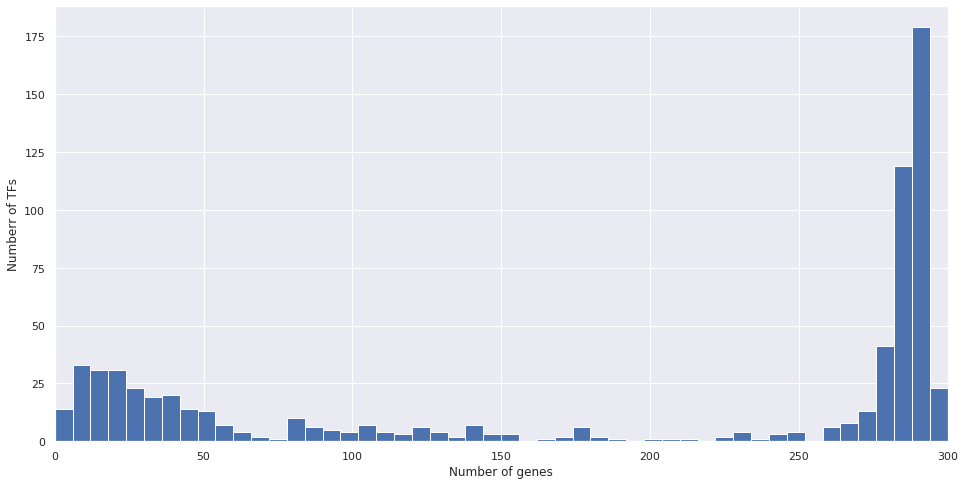

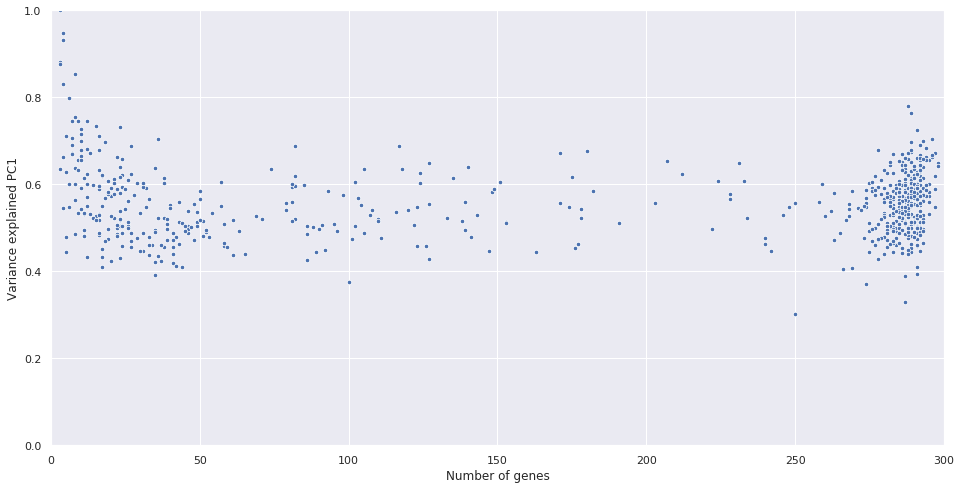

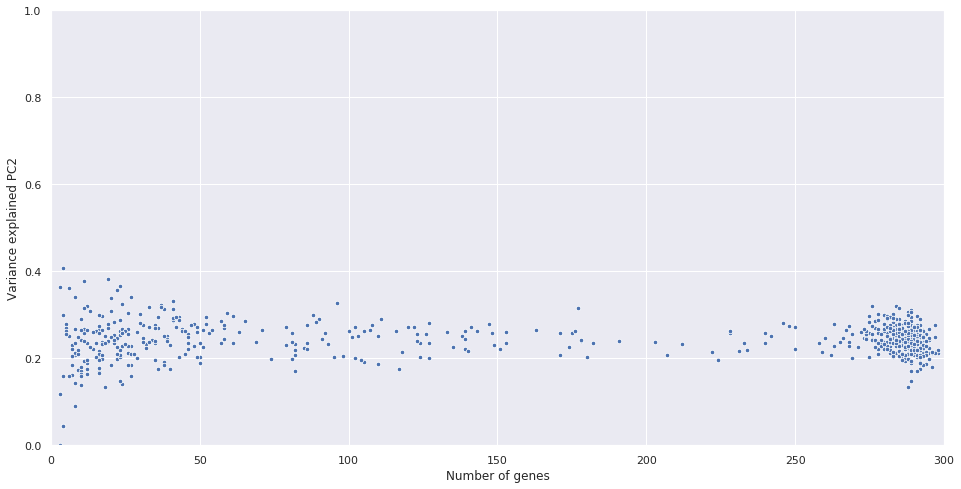

PC1       PC2  stage
0  -2.906529  0.704332   -5.5
1   0.932319  2.880924   -5.5
2  -2.137053  0.495952   -2.5
3  -1.434418  0.328252   -2.5
4  -1.196534 -0.592267    0.5
..       ...       ...    ...
7   0.366943 -0.171035    4.0
8  -0.366671  2.198302   22.0
9  -1.029158  3.446587   22.0
10 -1.976298  1.029578   29.0
11 -3.120863  1.985876   29.0

[8328 rows x 3 columns]

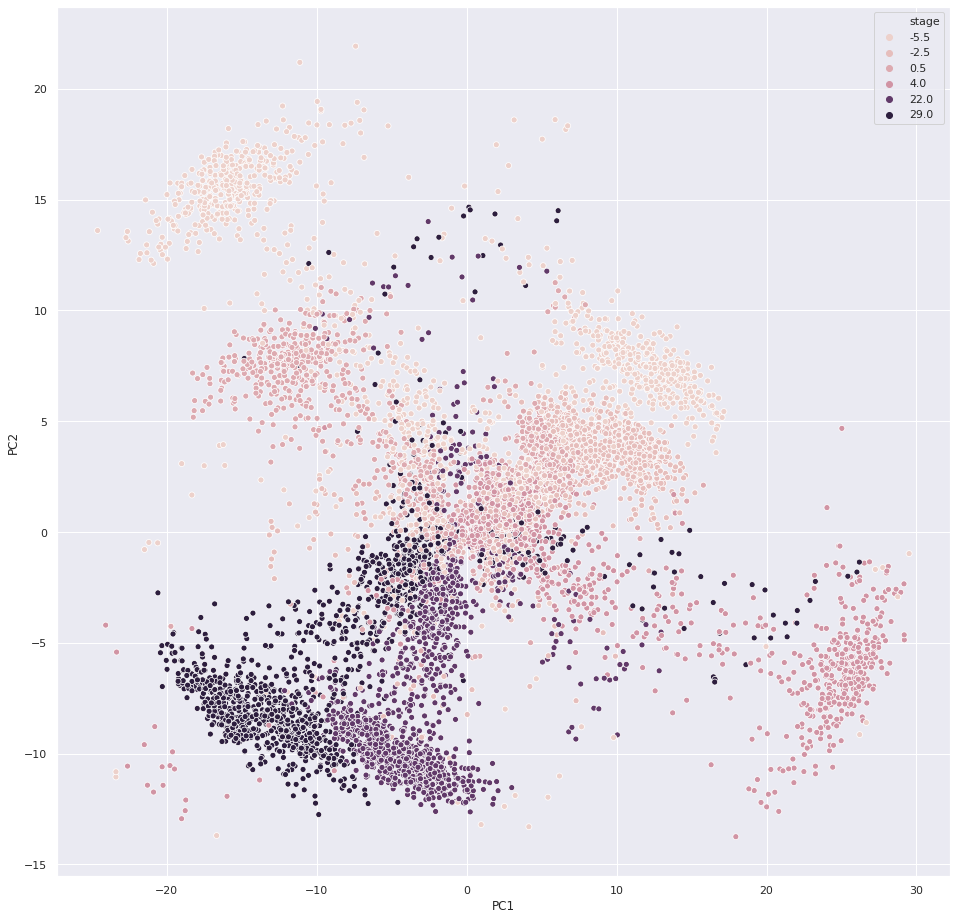

In [30]:
[a,b] = datacheck2(10,300,300,'liver')

Dataset contains 694 TFs
Dataset contains 0 TF(s) with only a single gene


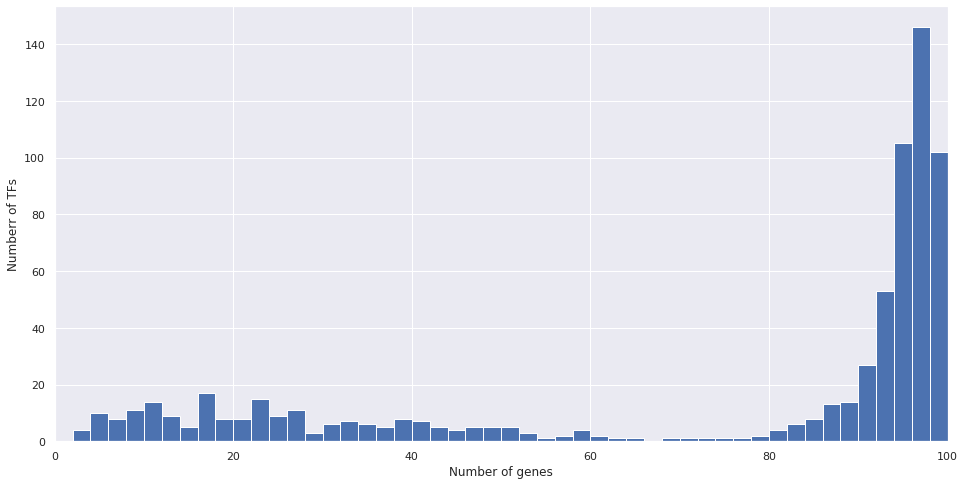

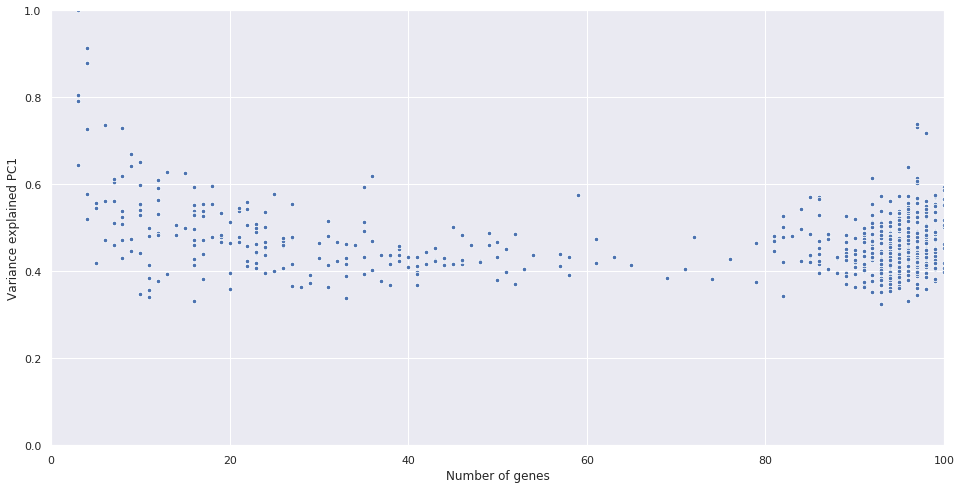

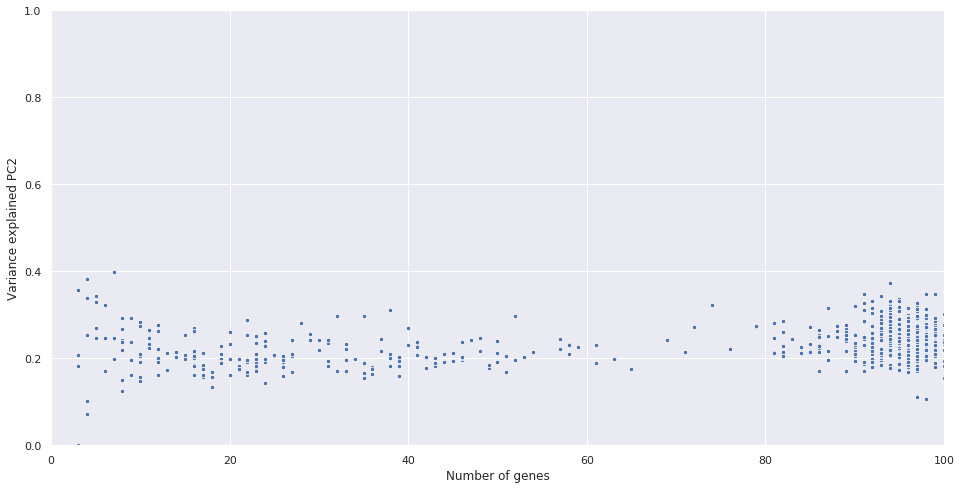

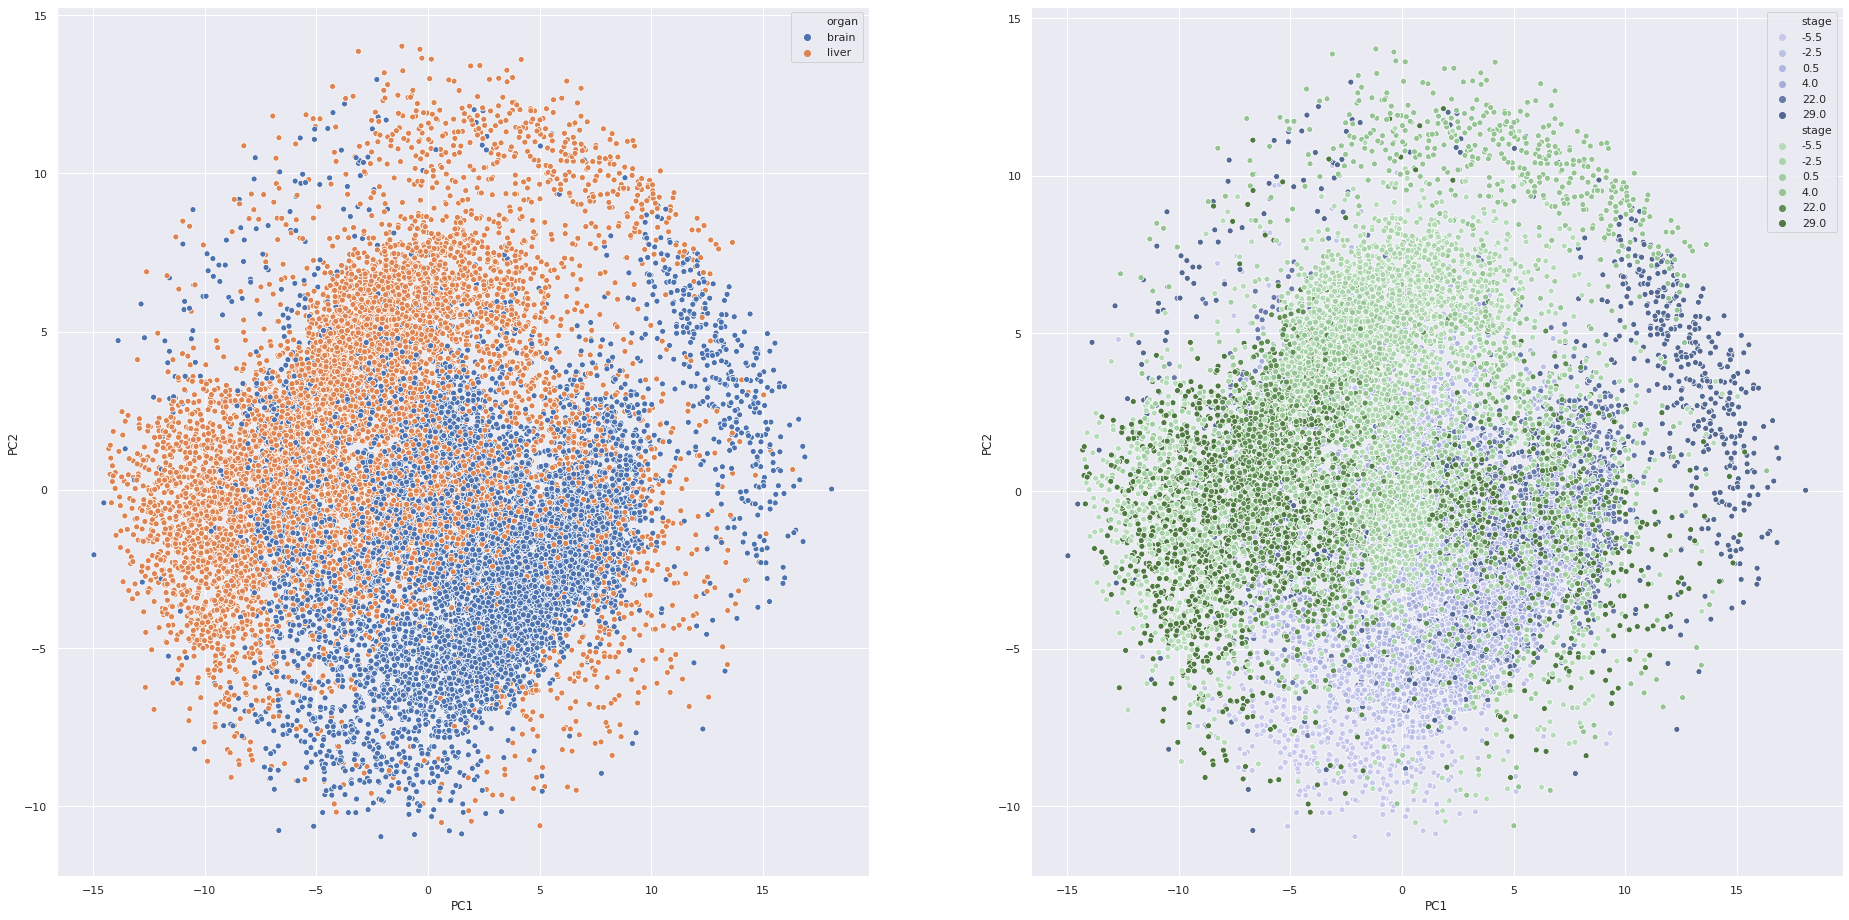

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [16]:
[a,b] = datacheck2(10,300,100)

Dataset contains 699 TFs
Dataset contains 0 TF(s) with only a single gene


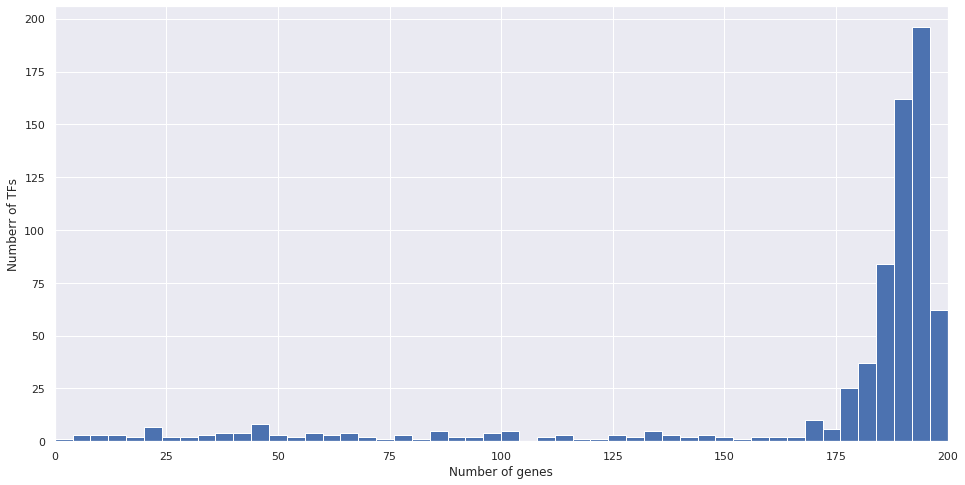

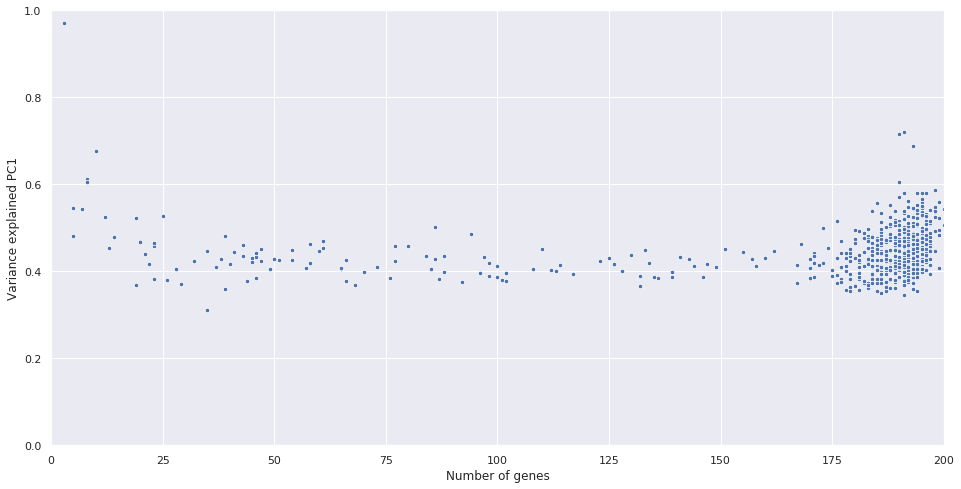

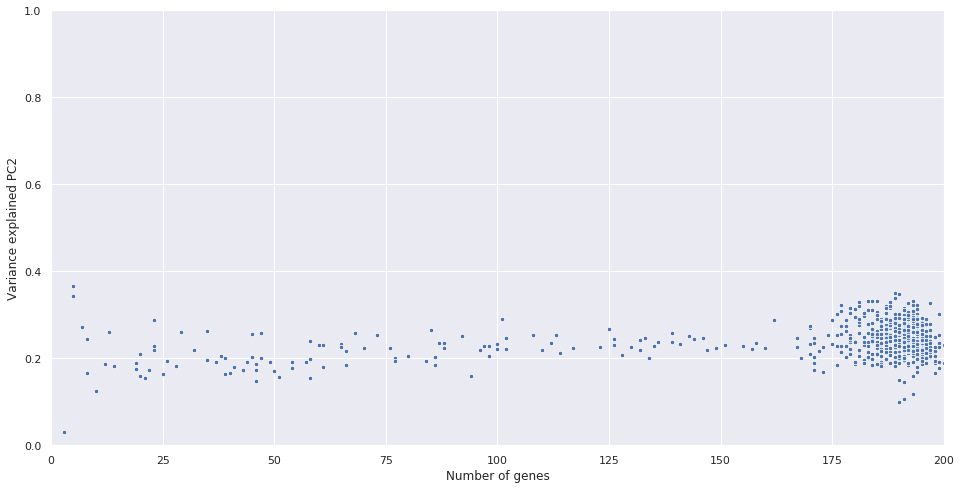

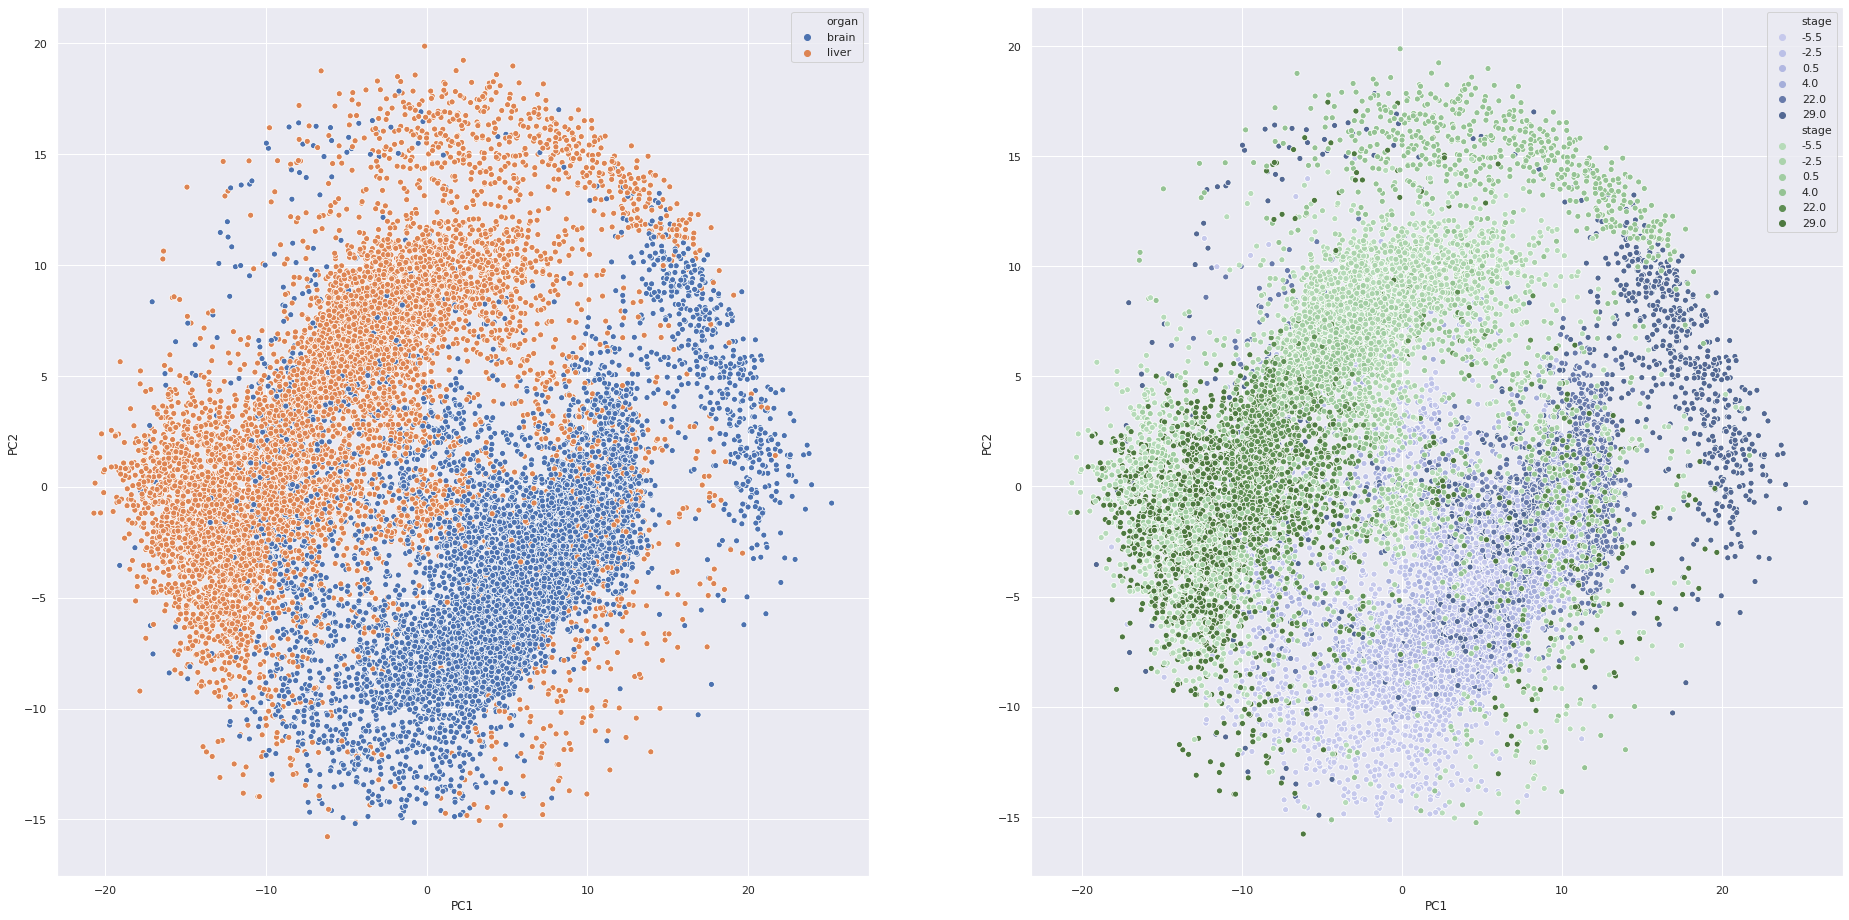

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [105]:
[res, cont] = datacheckTOP(10,200)

/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/augjan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: Pe

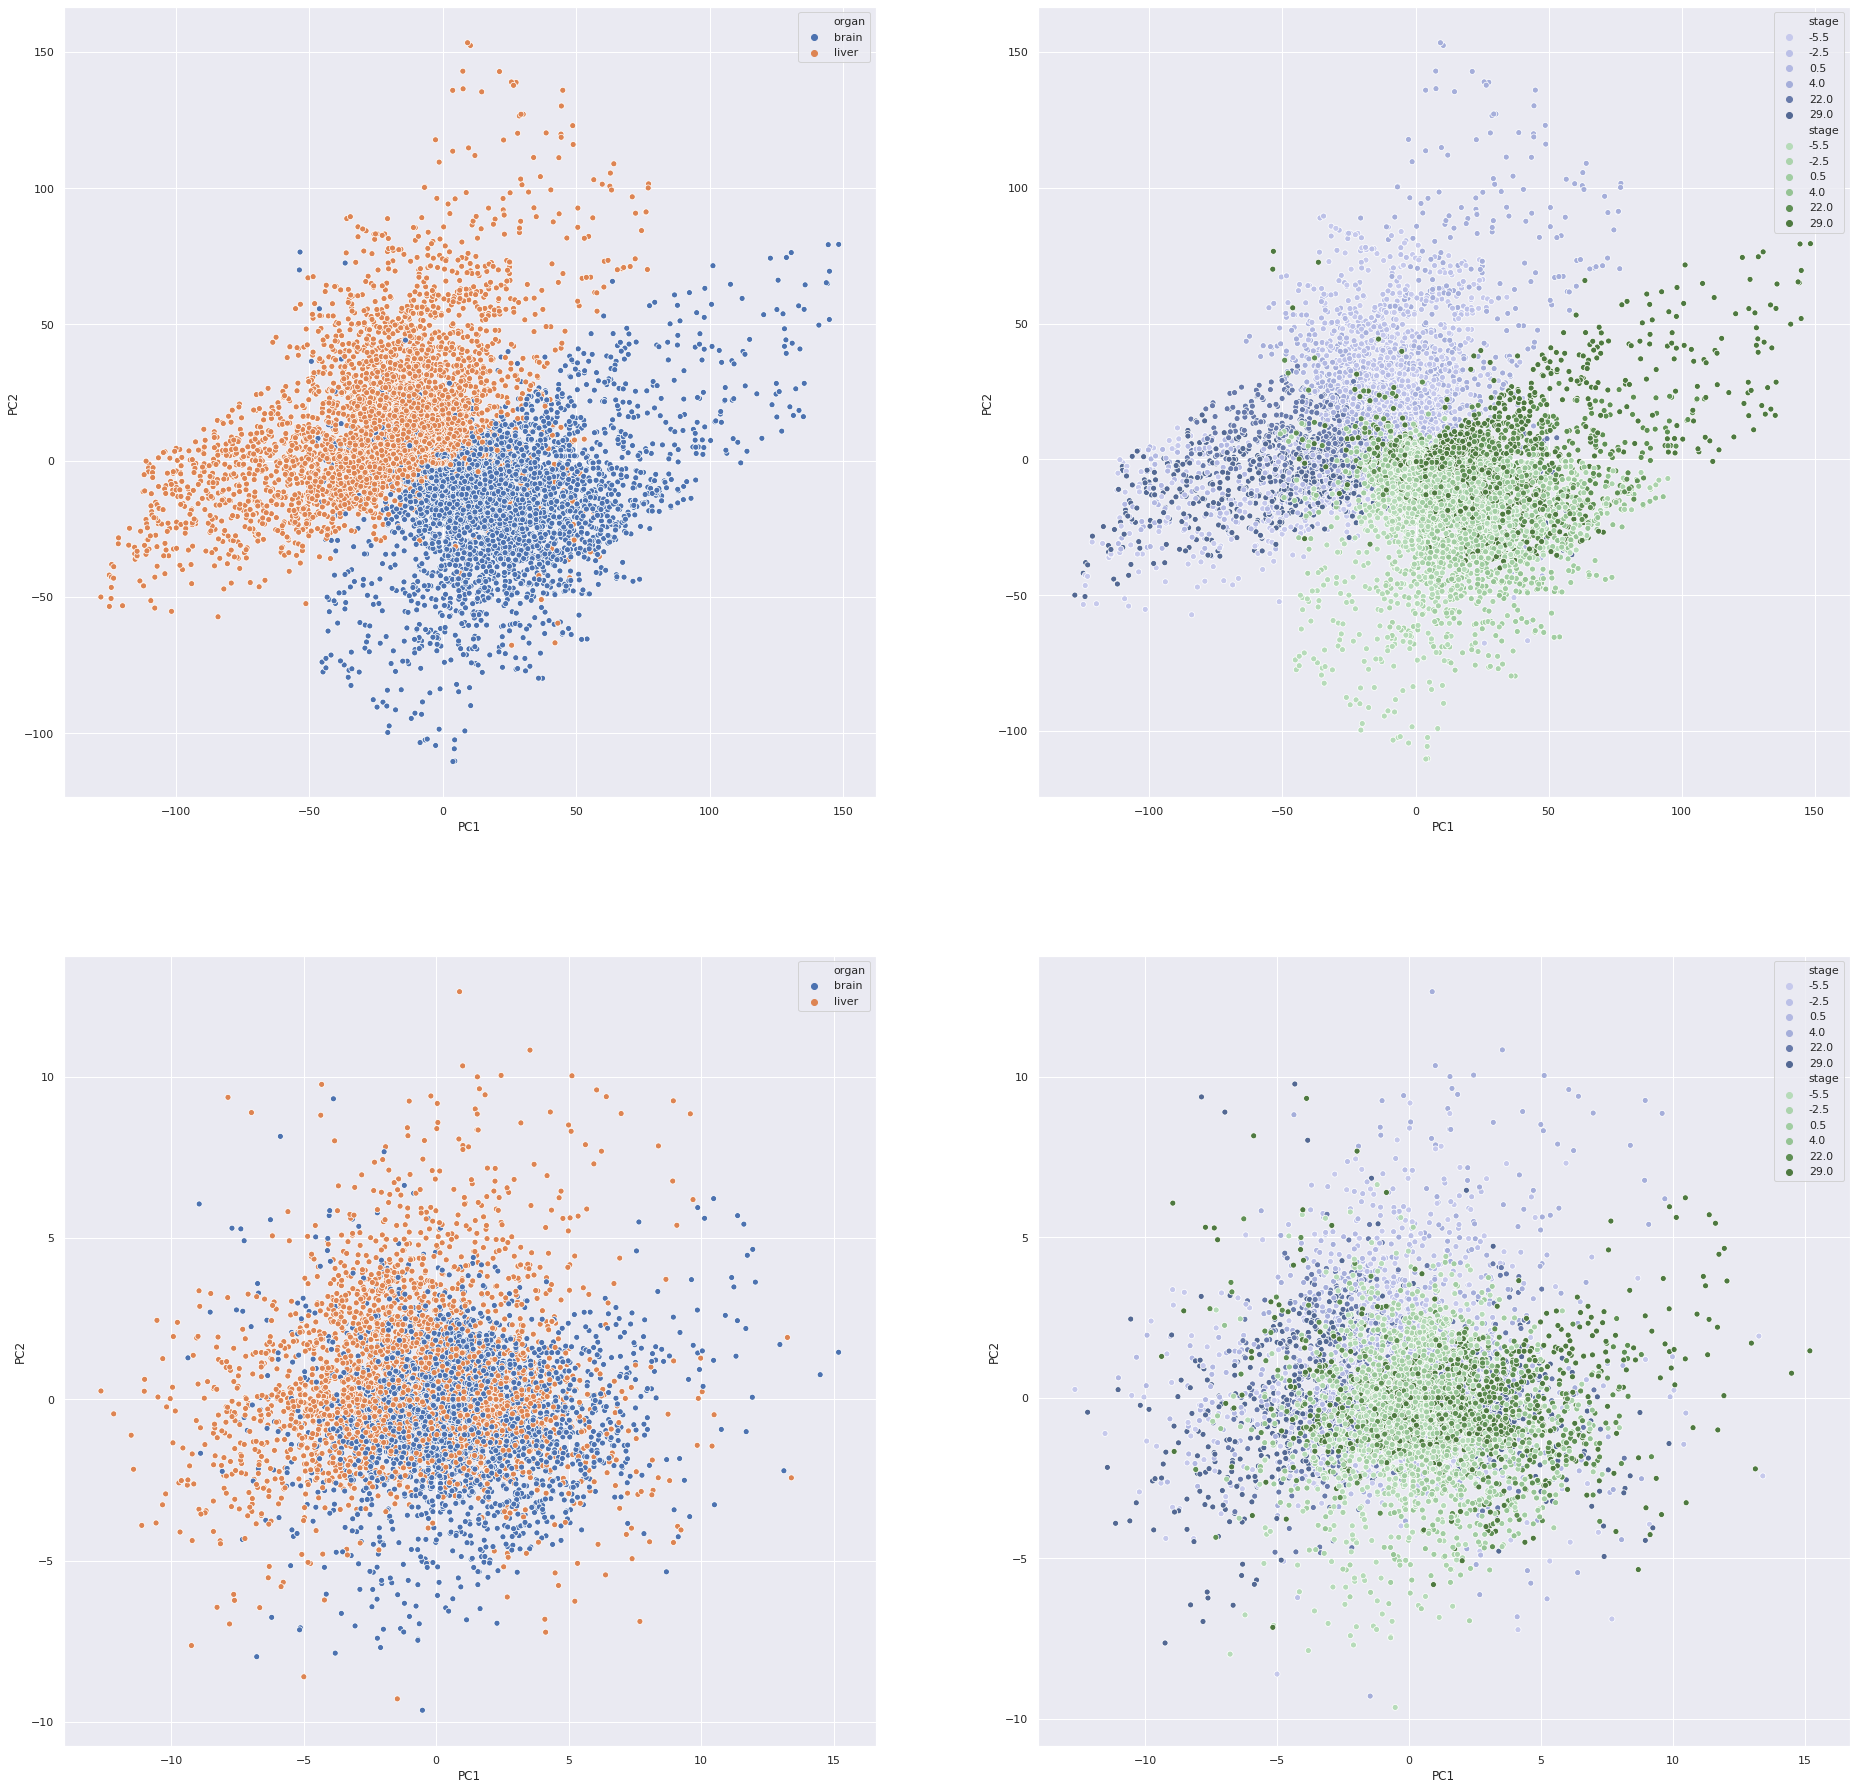

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [24]:
PCcheck(10,700,100)

## Old/unused code

In [8]:
def gene_sets_TOP(kbp, MAX):
    '''
    Fetch data on which genes may be regulated by each TF.
    '''
    # Read csv with all all TFs and urls to files with their target genes
    try:
        chip = pd.read_csv('../data/Transfactors/chip_atlas_analysis_list_CORRECTED.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    except FileNotFoundError:
        chip = csv_fix('../data/Transfactors/chip_atlas_analysis_list.csv').loc[1255:1953,['Antigen','Target Genes (TSS }1k)','Target Genes (TSS }5k)', 'Target Genes (TSS }10k)']]
    chip = chip.set_index('Antigen')

    #Read csv with TFs and their target genes. If not available, fetch the data and create a csv
    try: 
        TF_gene_sets = pd.read_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t', index_col='Antigen', converters={'Genes': lambda x: x.strip('[]').replace("'","").split(', ')})
    except FileNotFoundError:
        TF_gene_sets = TFs_targets_TOP(kbp, MAX, chip)
        
    return TF_gene_sets

def TFs_targets_strict(kbp, MACS2, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts genes with a high enough MACS2 and STRING
    binding score into a list that is then converted to a dataframe as output
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes') #For a specific TF, read csv from url as a dataframe
                genes = TF_gene_set.loc[(TF_gene_set > MACS2).sum(axis=1)>0,:].index.tolist() #Take the contents of column 'Target_genes' and puts it into a list for rows with a value above set MACS2 threshold
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_'+str(kbp)+'_'+str(MACS2)+'.tsv', sep='\t')
    return TF_gene_sets


def TFs_targets_TOP(kbp, MAX, chip): 
    '''
    Function for creating csv with all TFs and a strict selection of their potential target genes. For each TF, 
    it identifies urls for target genedata, fetches the info and puts up to a specified number of genes into a
    list. MACS2 scores are averaged across each sample type and genes with the highest MACS2 score, 
    considering all sample types, are selected for the list. The list is then coverted to a dataframe as
    output.
    '''
    TFrange = ('Target Genes (TSS }'+str(kbp)+'k)')
    TF_gene_list = []
    dex = 0
    t = 0
    for url in chip.loc[:,TFrange]: #OBS! This takes a long time.
        while t < 60:
            try:
                TF_gene_set = pd.read_csv(url, sep='\t', index_col='Target_genes').iloc[:,1:-1] #For a specific TF, read csv from url as a dataframe
                col = list(TF_gene_set.columns)
                for i in range(len(col)):
                    col[i] = col[i].split('|',1)[1]
                TF_gene_set.columns = col
                TF_set = pd.DataFrame(index=TF_gene_set.index, columns=set(col))
                for sample in TF_set.columns:
                    TF_set[sample] = TF_gene_set.loc[:,[sample]].mean(axis=1)
                TF_set['Max'] = TF_set.max(axis=1)
                genes = TF_set.nlargest(n=MAX, columns='Max').index.tolist()
                TF_gene_list.append(genes) #Append the list for a specific TF to list with all TFs
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') found')
            except HTTPError: #If the url does not exist, insert 'Not found' in the list and continue (to get correct index)                
                genes = []
                TF_gene_list.append(genes) #Append empty list for TFs for whose genes were not found or had too low score
                print('Genes for '+chip.index[dex]+' ('+str(dex)+') NOT found')
            except URLError: #If the url can't currently be reached, wait 2 sec and try again. Quit if takes too long.
                t=t+1
                print('Connection failed ('+str(t)+')! Retries in 2 sec...')
                time.sleep(2)
                continue
            break
        else:
            sys.exit('URLs could not be reached. Check your connection and its stability.')
        dex = dex+1
    TF_gene_sets = pd.DataFrame({'Genes':TF_gene_list}, index=chip.index) #Create a dataframe from the list of TFs and their target genes
    TF_gene_sets.drop(TF_gene_sets[TF_gene_sets.Genes == '[]'].index, inplace=True)
    TF_gene_sets.to_csv('../data/Transfactors/TF_gene_sets_top'+str(MAX)+'_'+str(kbp)+'kbp.tsv', sep='\t')
    return TF_gene_sets

def main_porch(kbp, MACS2,genelim):
    '''
    Main function for running the primary experiment, but using porch
    '''
    #Fetch data of which genes may be regulated by specific TFs, longitudinal mRNA expression data, and sample classification data
    TF_gene_sets = gene_sets_porch (kbp, MACS2)
    for TF in TF_gene_sets.index:
        if len(TF_gene_sets.loc[TF,:][0])>genelim:
            TF_gene_sets.drop(TF,inplace=True)
    [dataset, dataset2] = data_set()
    #Set index for expression data and log2 transform it
    expdata = indexing(dataset,dataset2)
    [PCA_results, untested] = porch(expdata, TF_gene_sets.reset_index(), gene_column='Genes', set_column='Antigen')

    return PCA_results, untested   